### Import dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean
import multiprocessing
from pdfo import pdfo,Bounds

import xarray as xr

xr.set_options(display_style='html')

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

## Tuning to CMIP6 forcing response 
Using the methodology of Cummins et al. (2020), we fit CMIP6 models to the EBM of Geoffrey based on a recursive Kalman filter MLE algorithm, using data from both the 1pctCO2 and abrupt-4xCO2 experiments to best constrain the parameters under both transient and equilibrium conditions.

#### Import the CMIP6 datasets

In [2]:
abrupt_4x_data = pd.read_csv('../tools/cmip6_data/abrupt-4xCO2.csv',index_col=0)
onepct_data = pd.read_csv('../tools/cmip6_data/onepct.csv',index_col=0)
picontrol_data = pd.read_csv('../tools/cmip6_data/piControl.csv',index_col=0)

for i,x in enumerate(['source','member','variable']):
    abrupt_4x_data.loc[x] = [x.split('_')[i+1] for x in abrupt_4x_data.columns]
    picontrol_data.loc[x] = [x.split('_')[i+1] for x in picontrol_data.columns]
    onepct_data.loc[x] = [x.split('_')[i+1] for x in onepct_data.columns]

abrupt_4x_data=abrupt_4x_data.T.set_index(['source','member','variable']).T
picontrol_data=picontrol_data.T.set_index(['source','member','variable']).T
onepct_data=onepct_data.T.set_index(['source','member','variable']).T

In [3]:
cmip6_exp_info = pd.read_csv('../tools/cmip6_data/cmip6_branch_info.csv',index_col=0)

## a few bits we'll need:

calendar_info = dict(zip(["<class 'cftime._cftime.DatetimeNoLeap'>","<class 'numpy.datetime64'>","<class 'cftime._cftime.DatetimeJulian'>","<class 'cftime._cftime.DatetimeProlepticGregorian'>","<class 'cftime._cftime.DatetimeGregorian'>","<class 'cftime._cftime.Datetime360Day'>"],[365,365.2422,365.25,365.2425,365.2425,360]))

cmip6_exp_info.loc['calendar_length'] = [calendar_info[x] for x in cmip6_exp_info.loc['calendar']]

for i,x in enumerate(['source','member','experiment']):
    cmip6_exp_info.loc[x] = [x.split('_')[i+1] for x in cmip6_exp_info.columns]
    
cmip6_exp_info=cmip6_exp_info.T.set_index(['source','member','experiment']).T

cmip6_exp_info.loc['parent_branch_time'] = cmip6_exp_info.loc['parent_branch_time'].astype(float)

cmip6_exp_info.loc['parent_branch_time','BCC-CSM2-MR'] = 281*cmip6_exp_info.loc['calendar_length','BCC-CSM2-MR'].values[0]
cmip6_exp_info.loc['parent_branch_time','BCC-ESM1'] = (2110-1850)*cmip6_exp_info.loc['calendar_length','BCC-ESM1'].values[0]
cmip6_exp_info.loc['parent_branch_time','CAMS-CSM1-0'] = 0.0
cmip6_exp_info.loc['parent_branch_time','MRI-ESM2-0'] = (cmip6_exp_info.loc['parent_branch_time','MRI-ESM2-0'].apply(pd.to_numeric)*cmip6_exp_info.loc['calendar_length','MRI-ESM2-0'].apply(pd.to_numeric)).values
cmip6_exp_info.loc['parent_branch_time',('TaiESM1','r1i1p1f1','abrupt-4xCO2')] = 500*365

cmip6_exp_info.loc['parent_variant','CNRM-ESM2-1'] = 'r1i1p1f2'
cmip6_exp_info.loc['parent_variant','CIESM'] = 'r1i1p1f1'

cmip6_exp_info.loc['parent_branch_time_years'] = [round(x) for x in cmip6_exp_info.loc['parent_branch_time'].apply(pd.to_numeric) / cmip6_exp_info.loc['calendar_length']]

# CanESM5 meta data actually measured relative to the time axes of the data, rather than to zero (as appears to be the case for other data)
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r1i1p1f1')] = 1850-5200 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r1i1p1f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r2i1p1f1')] = 1850-5200 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r2i1p1f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r3i1p1f1')] = 1850-5200 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r3i1p1f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r3i1p2f1')] = 1850-5550 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r3i1p2f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r2i1p2f1')] = 1850-5550 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r2i1p2f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r1i1p2f1')] = 1850-5550 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r1i1p2f1')].values

cmip6_exp_info.loc['parent_branch_time_years',('CanESM5-CanOE','r1i1p2f1')] = 1850-5550 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5-CanOE','r1i1p2f1')].values

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


### Simple baseline temperature estimation and drift correction

- We estimate the baseline temperature by:
    - If piControl data exists, from a linear regression of a 20 year period around the branch point. The linear model temperature at the branch point is the baseline temperature
    - If no piControl exists, we follow Sanderson (2020); and estimate the baseline temperature with a linear regression of the first 20 years of the 1pctCO2 run
    - If neither exists, we remove the model from our analysis
- We estimate the drift by:
    - using a linear regression of the piControl of the same length as the experiment data (if exists), starting from the branch point
    - If piControl length is insufficient, we use a linear regression of 150 years (or as long as the experiment data), ending in the final year of available piControl data
    
- Other points:
    - If the abrupt-4xCO2 data is less than 50 years in length, we remove the model
    - Before estimating parameters, we take the average of different ensemble members
    - If rsdt does not exist for abrupt-4xCO2, we use data from piControl or onepct if availablepicontrol_data

In [4]:
## let's get the baseline temps / drift slopes from the piControl:

def get_intercept_slope_tas(model,member,length):

    picontrol_member = cmip6_exp_info.loc['parent_variant',(model,member,'abrupt-4xCO2')]
    picontrol_tas = picontrol_data[model][picontrol_member]['tas'].dropna().astype(float)
    branch_point = cmip6_exp_info.loc['parent_branch_time_years',(model,member,'abrupt-4xCO2')]
    
    if (branch_point + length) < picontrol_tas.size:
        start = branch_point
        end = branch_point+length
        startidx = 0
        endidx=length
    else:
        if picontrol_tas.size < length:
            length = picontrol_tas.size
        start = picontrol_tas.size - length
        end = None
        startidx = start - branch_point
        endidx = start - branch_point + length
    
    _lr = sp.stats.linregress(np.arange(startidx,endidx),picontrol_tas.iloc[start:end])
    
    return _lr.intercept, _lr.slope

In [5]:
tas_baseline_slope = pd.DataFrame(index=['intercept','slope'],columns=abrupt_4x_data.xs('tas',axis=1,level=-1).columns)

for mod_mem in abrupt_4x_data.xs('tas',axis=1,level=-1).columns:
    
    abrupt_4x_length = abrupt_4x_data[mod_mem[0]][mod_mem[1]].dropna().shape[0]
    
    if abrupt_4x_length<50:
        continue
    
    tas_baseline_slope.loc[:,mod_mem] = get_intercept_slope_tas(mod_mem[0],mod_mem[1],abrupt_4x_length)

In [6]:
## let's get the baseline temps / drift slopes from the piControl:

def get_intercept_slope_N(model,member,length):

    picontrol_member = cmip6_exp_info.loc['parent_variant',(model,member,'abrupt-4xCO2')]
    picontrol_all = picontrol_data[model][picontrol_member].astype(float)
    if not ('rsut' in picontrol_all.columns and 'rlut' in picontrol_all.columns):
        return np.nan
        
    if len(set(picontrol_all.rsut.dropna().index).intersection(set(picontrol_all.rlut.dropna().index)))<100:
        return picontrol_all.rsut.mean() + picontrol_all.rlut.mean(),0
        
    picontrol_N = (picontrol_all.rsut + picontrol_all.rlut).dropna()
    
    branch_point = cmip6_exp_info.loc['parent_branch_time_years',(model,member,'abrupt-4xCO2')]
    
    if (branch_point + length) < picontrol_N.size:
        start = branch_point
        end = branch_point+length
        startidx = 0
        endidx=length
    else:
        if picontrol_N.size < length:
            length = picontrol_N.size
        start = picontrol_N.size - length
        end = None
        startidx = start - branch_point
        endidx = start - branch_point + length
    
    _lr = sp.stats.linregress(np.arange(startidx,endidx),picontrol_N.iloc[start:end])
    
    return _lr.intercept, _lr.slope

In [7]:
N_baseline_slope = pd.DataFrame(index=['intercept','slope'],columns=abrupt_4x_data.xs('tas',axis=1,level=-1).columns)

for mod_mem in abrupt_4x_data.xs('tas',axis=1,level=-1).columns:
    
    abrupt_4x_length = abrupt_4x_data[mod_mem[0]][mod_mem[1]].dropna().shape[0]
    
    if abrupt_4x_length<50:
        continue
    
    N_baseline_slope.loc[:,mod_mem] = get_intercept_slope_N(mod_mem[0],mod_mem[1],abrupt_4x_length)

In [8]:
## now we compute the drift corrected anomaly datasets:
abrupt_4x_data_corr = pd.concat([pd.DataFrame(index = list(np.arange(2000)), columns = abrupt_4x_data.xs('tas',axis=1,level=-1).columns)]*2,axis=1,keys=['tas','N']).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1)

for mod_mem in abrupt_4x_data.xs('tas',axis=1,level=-1).columns:
    
    if mod_mem in N_baseline_slope.dropna(axis=1).columns and mod_mem in tas_baseline_slope.dropna(axis=1).columns:
        
        if 'rsut' in abrupt_4x_data.loc[:,mod_mem].columns and 'rlut' in abrupt_4x_data.loc[:,mod_mem].columns and 'tas' in abrupt_4x_data.loc[:,mod_mem].columns:
        
            mod_tas_data = abrupt_4x_data.loc[:,mod_mem].tas.astype(float).dropna()
            abrupt_4x_data_corr.loc[:mod_tas_data.size-1,(*mod_mem,'tas')] = mod_tas_data.values - tas_baseline_slope.loc['intercept',mod_mem] - np.arange(mod_tas_data.size) * tas_baseline_slope.loc['slope',mod_mem]

            mod_N_data = (abrupt_4x_data.loc[:,mod_mem].rsut.astype(float)+abrupt_4x_data.loc[:,mod_mem].rlut.astype(float)).dropna()
            abrupt_4x_data_corr.loc[:mod_tas_data.size-1,(*mod_mem,'N')] = mod_N_data.values - N_baseline_slope.loc['intercept',mod_mem] - np.arange(mod_N_data.size) * N_baseline_slope.loc['slope',mod_mem]

In [9]:
# these members have something off (GISS just looks wrong, MRI appear to have been started at some point DURING the year...)
abrupt_4x_data_corr = abrupt_4x_data_corr.drop([('GISS-E2-1-G','r1i1p1f3','tas'),('GISS-E2-1-G','r1i1p1f3','N'),\
                         ('MRI-ESM2-0','r4i1p1f1','tas'),('MRI-ESM2-0','r4i1p1f1','N'),\
                         ('MRI-ESM2-0','r7i1p1f1','tas'),('MRI-ESM2-0','r7i1p1f1','N')],axis=1).dropna(axis=1,how='all').apply(pd.to_numeric)

## these next members appear to have a year of picontrol at the start
abrupt_4x_data_corr.loc[:1998,('MRI-ESM2-0',['r10i1p1f1','r13i1p1f1'])] = abrupt_4x_data_corr.loc[1:,('MRI-ESM2-0',['r10i1p1f1','r13i1p1f1'])].values

In [10]:
fit_data = abrupt_4x_data_corr.fillna(np.inf).groupby(level=(0,2),axis=1).mean().replace(np.inf, np.nan)

#### Create the required definitions

In [13]:
def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def Kalman(a0, P0, dt, ct, Tt, Zt, HHt, GGt, yt):
    
    # computes a Kalman filter recursively over all the timesteps of the input data, yt
    # returns the Negative log likelihood for fitting
    
    n = yt.shape[1] # measurements
    k = a0.shape[0] # state dimension size
    d = yt.shape[0] # measurement dimensions
    vt = np.zeros((d,n))
    Ft = np.zeros((d,d,n))
    Kt = np.zeros((k,d,n))
    at = np.zeros((k,n+1))
    Pt = np.zeros((k,k,n+1))
    nll = 0

    at[...,0] = a0
    Pt[...,0] = P0

    for i in np.arange(n):
        vt[...,i] = yt[...,i] - ct - Zt @ at[...,i]
        Ft[...,i] = Zt @ Pt[...,i] @ Zt.T + GGt
        Kt[...,i] = Pt[...,i] @ Zt.T @ np.linalg.inv(Ft[...,i])
        att = at[...,i] + Kt[...,i] @ vt[...,i]
        Ptt = Pt[...,i] - Pt[...,i] @ Zt.T @ Kt[...,i].T

        at[...,i+1] = dt[...,i] + Tt@att
        Pt[...,i+1] = Tt @ Ptt @ Tt.T + HHt
        
        nll += np.log(2*np.pi) + (1/2) * (  np.log(np.linalg.det(Ft[...,i])) + vt[...,i].T @ np.linalg.inv(Ft[...,i]) @ vt[...,i] )
        
    return nll

In [14]:
def nll_abrupt4x(par,yt,transform=True):
    
    if transform:
        par = np.exp(par)
    
    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(par)
    k = A.shape[0]
    u = np.full(yt.shape[-1],par[-1]).reshape(1,-1)
    
    gamma0 = (sp.linalg.solve(np.identity(k**2)-np.kron(A_d,A_d),Q_d.flatten())).reshape(4,4)
    x0 = np.array([par[-1],0,0,0])
    a0 = A_d@x0 + b_d*u[...,0]
    
    P0 = gamma0.copy()
    dt = (b_d.reshape(-1,1)@u)
    ct = np.zeros(2)
    Tt = A_d.copy()
    Zt = C_d.copy()
    HHt = Q_d.copy()
    GGt = np.identity(2)*1e-15
    
    return Kalman(a0, P0, dt, ct, Tt, Zt, HHt, GGt, yt)

In [15]:
def visual_check_abrupt4x(source,fit_params):

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    CMIP6_data = fit_data[source].dropna()
    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(fit_params)
    
#     w_d = sp.stats.multivariate_normal(mean = None , cov = Q_d, allow_singular=True)
    
    x = np.zeros((CMIP6_data.shape[0]+1,4))
    y = np.zeros((CMIP6_data.shape[0]+1,2))
    
    x[:,0] = fit_params[-1]
    y[0,:] = C_d @ x[0]
    
    for t in np.arange(x.shape[0]-1):
        x[t+1] = A_d@x[t]+b_d*fit_params[-1]
        y[t+1] = C_d@x[t+1]
    
    ax[0].plot(np.arange(CMIP6_data.shape[0]),y[1:,0],ls='--')
    ax[0].plot(np.arange(CMIP6_data.shape[0]),CMIP6_data['tas'].values)
    ax[1].plot(np.arange(CMIP6_data.shape[0]),y[1:,1],ls='--')
    ax[1].plot(np.arange(CMIP6_data.shape[0]),-1*CMIP6_data['N'].values,label=source)
    ax[2].plot(y[1:,0],y[1:,1],ls='--')
    ax[2].plot(CMIP6_data['tas'].values,-1*CMIP6_data['N'].values,'o',ms=1,zorder=0)
    
    ax[0].set_title('tas')
    ax[1].set_title('TOA EB')
    ax[2].set_title('tas / TOA EB')
    
    fig.suptitle(source+' verification',fontweight='bold')
    
    return y

In [16]:
def fit_source(source,plot_output=False):
    
#     print('getting data for '+source)
    
    abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
    # param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']
    
    par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

    print('fitting '+source)
    
    fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),options={'maxfev':20000})
    
    if fit_params.success==1:
        print(source+' fit converged')
        
        if plot_output:
            visual_check_abrupt4x(source,np.exp(fit_params.x))
            plt.show()

        return pd.Series(np.exp(fit_params.x),index=['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_4x']).rename(source)
    
    else:
        print('trying BOBYQA')
        fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})
        
        if fit_params.success==1:
            print(source+' fit converged with BOBYQA')
        
            if plot_output:
                visual_check_abrupt4x(source,np.exp(fit_params.x))
                plt.show()

            return pd.Series(np.exp(fit_params.x),index=['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_4x']).rename(source)
    
        else:
        
            print(source+' fit failed')
            return None

### Fitting the CMIP6 ensemble

In [ ]:
result_abrupt4x = []
for source in fit_data.columns.levels[0]:
    result_abrupt4x += [fit_source(source,True)]

In [ ]:
res_df = pd.concat(result_abrupt4x,axis=1)
res_df

In [ ]:
## Failed

failed_sources = ['BCC-CSM2-MR','CNRM-CM6-1','CESM2','EC-Earth3-Veg','MIROC-ES2L','NorESM2-LM','NorESM2-MM']

fig,ax = plt.subplots(2,4,figsize=(20,8))

for i,x in enumerate(failed_sources):
#     fit_data[x]['tas'].plot(ax=ax.flatten()[i])
#     (-1*fit_data[x]['N']).plot(ax=ax.flatten()[i])
    ax.flatten()[i].plot(fit_data[x]['tas'],(-1*fit_data[x]['N']),'o',ms=1)
    ax.flatten()[i].set_title(x)

In [ ]:
source = failed_sources[0]
plot_output=True

abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 6.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [ ]:
res_df.loc[:,failed_sources[0]] = np.exp(fit_params.x)

In [ ]:
source = failed_sources[1]
b, a = sp.signal.butter(2 , 0.3)
plt.plot(sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values),'o',ms=1)
plt.plot(fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values,'o',zorder=0,ms=1)

In [ ]:
source = failed_sources[1]
plot_output=True

b, a = sp.signal.butter(2 , 0.2)
abrupt4x_yt = np.array([sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values)])

abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 7.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='lincoa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [ ]:
res_df.loc[:,source] = np.exp(fit_params.x)

In [ ]:
source = failed_sources[2]
plot_output=True

abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 8.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [ ]:
res_df.loc[:,source] = np.exp(fit_params.x)

In [ ]:
source = failed_sources[3]
plot_output=True

abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 8.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [ ]:
res_df.loc[:,source] = np.exp(fit_params.x)

In [ ]:
source = failed_sources[4]
b, a = sp.signal.butter(2 , 0.3)
plt.plot(sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values),'o',ms=1)
plt.plot(fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values,'o',zorder=0,ms=1)

In [ ]:
source = failed_sources[4]
plot_output=True

b, a = sp.signal.butter(2 , 0.2)
abrupt4x_yt = np.array([sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values[:-1]),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values[:-1])])

# abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values[:-1],-1*fit_data.loc[:,(source,'N')].dropna().values[:-1]])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

lb = np.log([0.1,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,0.4,0.1,0.1,4])
ub = np.log([4,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,100,3,3,13])
bounds = Bounds(lb,ub)

par0 = np.array([1.88697708e+00, 4.8, 14, 250, 1.926, 1.48, 0.78, 0.4 ,6.92283697e-01, 9.77460421e-01, 8.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [ ]:
res_df.loc[:,source] = np.exp(fit_params.x)

In [ ]:
source = failed_sources[5]
b, a = sp.signal.butter(2 , 0.25)
plt.plot(sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values),'o',ms=1)
plt.plot(fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values,'o',zorder=0,ms=1)

In [ ]:
source = failed_sources[5]
plot_output=True

b, a = sp.signal.butter(2 , 0.25)
abrupt4x_yt = np.array([sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values)])

# abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 50, 200, 0.4, 2.7, 3.2, 4, 0.5, 0.5, 8.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

lb = np.log([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,9.86])
ub = np.log([40,10,np.inf,2000,3,40,100,np.inf,3,1,9.87])
bounds = Bounds(lb,ub)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()
else:
    print(source+' fit failed')

In [ ]:
res_df.loc[:,source] = np.exp(fit_params.x)

In [ ]:
source = failed_sources[6]
b, a = sp.signal.butter(2 , 0.2)
plt.plot(sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values)[:-10],-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values)[:-10],'o',ms=1)
plt.plot(fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values,'o',zorder=0,ms=1)

In [ ]:
source = failed_sources[6]
plot_output=True

b, a = sp.signal.butter(2 , 0.2)
abrupt4x_yt = np.array([sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values)[:-10],-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values)[:-10]])

# abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 2, 0.5, 0.5, 8])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

lb = np.log([1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1,1e-9,1e-9,5])
ub = np.log([np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,15])
bounds = Bounds(lb,ub)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),bounds=bounds,method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()
        
else:
    print(source+' fit failed')

In [ ]:
x = np.array([1.3830042,   4.1292158, 128.2617831  , 0.5880654   ,1.9660150,   1.4412264 ,  0.7009993, 207.4768558,   1.2269853 ,  0.7049990,  10.8311735])
visual_check_abrupt4x(source,x)
print(nll_abrupt4x(np.log(x),abrupt4x_yt,True))

In [ ]:
res_df.loc[:,source] = np.exp(fit_params.x)

## plotting CESM2 and NorESM2 gregory 

[None, None, None]

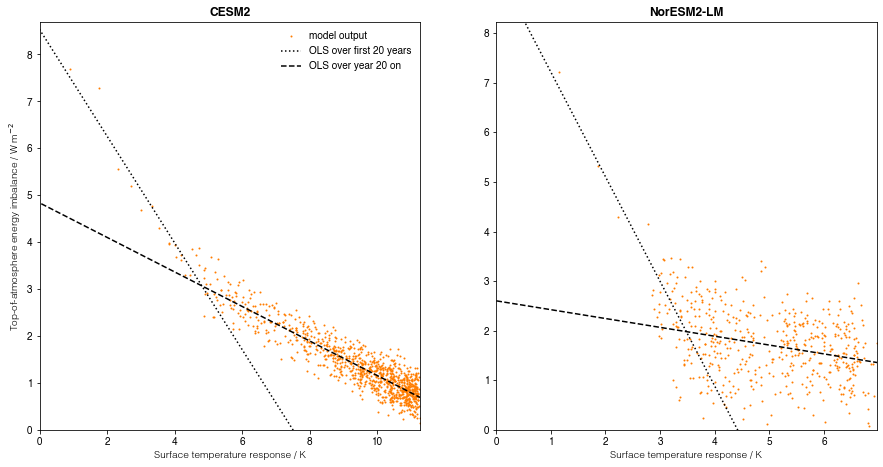

In [59]:
fig,ax = plt.subplots(1,2,figsize=(15,7.5))

for i,x in enumerate(['CESM2','NorESM2-LM']):

    ax[i].plot(fit_data.loc[:,(x,'tas')],-fit_data.loc[:,(x,'N')],'o',c='#FF7D00',ms=1,label='model output')
    _lr_20 = sp.stats.linregress(fit_data.loc[:20,(x,'tas')].values,-fit_data.loc[:20,(x,'N')].values)
    ax[i].plot(np.arange(-1,10),_lr_20.intercept+np.arange(-1,10)*_lr_20.slope,'k:',label='OLS over first 20 years')

    _lr_full = sp.stats.linregress(fit_data.loc[20:,(x,'tas')].dropna().values,-fit_data.loc[20:,(x,'N')].dropna().values)
    ax[i].plot(np.arange(-1,15),_lr_full.intercept+np.arange(-1,15)*_lr_full.slope,'k--',label='OLS over year 20 on')

    ax[i].set_xlim(0,fit_data.loc[:,(x,'tas')].max())
    ax[i].set_ylim(0,-fit_data.loc[:,(x,'N')].min()+1)
    
    ax[i].set_title(x,fontweight='bold')
    ax[i].set_xlabel('Surface temperature response / K')
    
ax[0].set_ylabel('Top-of-atmosphere energy imbalance / W m$^{-2}$')
ax[0].legend(loc='upper right')

[fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/CESM2_NorESM_Gregory.'+x,bbox_inches='tight',dpi=600) for x in ['png','pdf','svg']]

## Checking the Cummins algorithm fits

In [17]:
cummins_results = pd.concat([pd.read_csv('../../../CMIP6_data_fitting/CMIP6_bias_corr_results/'+x+'.csv',usecols=[1]).iloc[:,0].rename(x) for x in fit_data.columns.levels[0]],axis=1)
cummins_results.index = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds','stdx', 'F_4x']

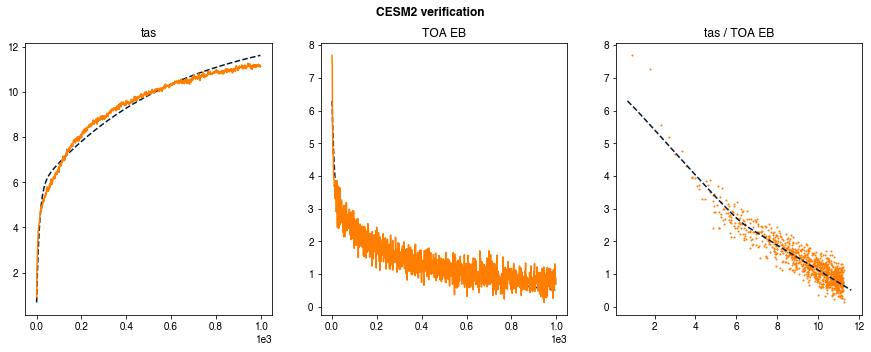

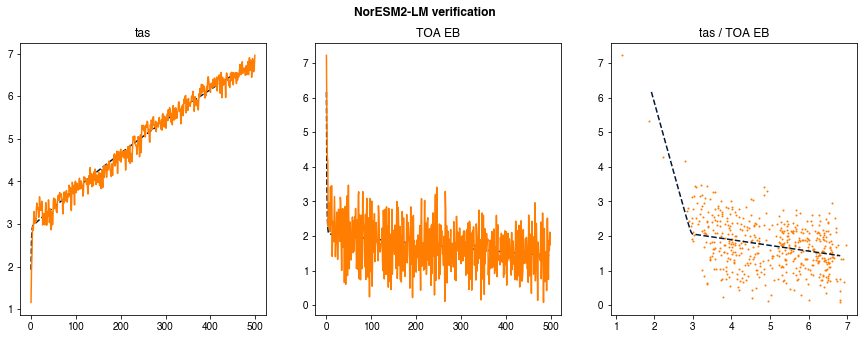

In [18]:
for source in fit_data.columns.levels[0]:
    visual_check_abrupt4x(source,cummins_results.loc[:,source])
    plt.show()

In [ ]:
for source in list(res_df.columns):
    if source in ['CESM2','MIROC-ES2L']:
        continue
    res_df.loc[:,source] = cummins_results.loc[:,source].values

In [ ]:
# res_df.to_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv')

## Estimating F_2x through measuring TCR

#### drift correction + baseline temp estimation

In [10]:
## let's get the baseline temps / drift slopes from the piControl:

def get_intercept_slope_tas(model,member,length):

    picontrol_member = cmip6_exp_info.loc['parent_variant',(model,member,'1pctCO2')]
    picontrol_tas = picontrol_data[model][picontrol_member]['tas'].dropna().astype(float)
    branch_point = cmip6_exp_info.loc['parent_branch_time_years',(model,member,'1pctCO2')]
    
    if (branch_point + length) < picontrol_tas.size:
        start = branch_point
        end = branch_point+length
        startidx = 0
        endidx=length
    else:
        if picontrol_tas.size < length:
            length = picontrol_tas.size
        start = picontrol_tas.size - length
        end = None
        startidx = start - branch_point
        endidx = start - branch_point + length
    
    _lr = sp.stats.linregress(np.arange(startidx,endidx),picontrol_tas.iloc[start:end])
    
    onepct_member = onepct_data[model][member]['tas'].dropna().values.astype(float)
    baseline_estimate = sp.stats.linregress(np.arange(1,26),onepct_member[:25]).intercept
    
    return baseline_estimate, _lr.slope

tas_baseline_slope_onepct = pd.DataFrame(index=['intercept','slope'],columns=onepct_data.xs('tas',axis=1,level=-1).columns)

for mod_mem in onepct_data.xs('tas',axis=1,level=-1).columns:
    
    onepct_length = onepct_data[mod_mem[0]][mod_mem[1]].dropna().shape[0]
    
    if onepct_length<50:
        continue
    
    tas_baseline_slope_onepct.loc[:,mod_mem] = get_intercept_slope_tas(mod_mem[0],mod_mem[1],onepct_length)

In [11]:
## now we compute the drift corrected anomaly datasets:
onepct_data_corr = pd.DataFrame(index = list(np.arange(2000)), columns = onepct_data.xs('tas',axis=1,level=-1).columns)

for mod_mem in onepct_data.xs('tas',axis=1,level=-1).columns:
        
        mod_tas_data = onepct_data.loc[:,mod_mem].tas.astype(float).dropna()
        onepct_data_corr.loc[:mod_tas_data.size-1,(mod_mem)] = mod_tas_data.values - tas_baseline_slope_onepct.loc['intercept',mod_mem] - np.arange(mod_tas_data.size) * tas_baseline_slope_onepct.loc['slope',mod_mem]

In [ ]:
TCR_values = onepct_data_corr.loc[60:79].mean().groupby(level=0).mean()

In [ ]:
def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    return pd.DataFrame([tau,q],index=['d','q'],columns=[1,2,3])

In [ ]:
res_df = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

In [ ]:
## Better way to fit F_2x based on observed TCR values:
res_df.loc['F_2x'] = np.nan

for model in res_df.columns:
    
    if model in TCR_values.index:

        fair_params = convert_geoffrey_to_FaIR(res_df.loc[:,model].iloc[:10])

        res_df.loc['F_2x',model] = TCR_values.loc[model]/( fair_params.loc['q'] * (1 - (fair_params.loc['d']/70) * ( 1 - np.exp(-70/fair_params.loc['d']) ) ) ).sum()
        
    else:
        continue#res_df.loc['F_2x',model] = res_df.loc['F_4x',model] /2

In [ ]:
res_df.to_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv')

## Fitting carbon cycle parameters to 1pctCO2 runs

In [17]:
## get emissions / temp data for onepct runs

model_listing = [x for x in glob.glob('/home/leachl/Documents/Datasets/CMIP6/CMIP6_TCRE/CMIP6_TCRE/*') if 'data.txt' in x]
models =  [x.split('/')[-1].split('_')[0] for x in model_listing]
model_1pct = pd.concat([pd.read_csv(x,delim_whitespace=True,header=None,names=['year','E','T'],index_col=0) for x in model_listing],axis=1,keys=models)
model_1pct.columns.set_levels(['BCC-CSM2-MR','CNRM-ESM2-1','UKESM1-0-LL','CanESM5','MIROC-ES2L','MPI-ESM1-2-LR','IPSL-CM6A-LR'],level=0,inplace=True) 

In [18]:
## get co2 data
co2data = pd.read_csv('../tools/cmip6_data/co2.csv',index_col=0)
co2data.columns = pd.MultiIndex.from_tuples([tuple(x.split('_')) for x in  co2data.columns])
co2data = co2data.xs('1pctCO2',axis=1,level=-1).droplevel((0,3),axis=1)

## get co2 data
co2massdata = pd.read_csv('../tools/cmip6_data/co2mass.csv',index_col=0)
co2massdata.columns = pd.MultiIndex.from_tuples([tuple(x.split('_')) for x in  co2massdata.columns])
co2massdata = co2massdata.xs('1pctCO2',axis=1,level=-1).droplevel((0,3),axis=1)

co2data = co2data.groupby(axis=1,level=0).mean().loc[:,[x for x in co2data.columns.levels[0] if x in model_1pct.columns.levels[0]]]

co2massdata = co2massdata.groupby(axis=1,level=0).mean().loc[:,[x for x in co2massdata.columns.levels[0] if x in model_1pct.columns.levels[0]]]

conc_data = pd.DataFrame(index = np.arange(400),columns = model_1pct.columns.levels[0])

for model in co2massdata.columns:
    model_data = co2massdata[model].dropna() / (5.1480 * 10e11) * 28.97 / 44.01
    conc_data.loc[:model_data.size-1,model] = model_data.values
    
for model in co2data.columns:
    model_data = co2data[model].dropna() * 1e6
    conc_data.loc[:model_data.size-1,model] = model_data.values
    
conc_data.loc[:,['CanESM5','MIROC-ES2L']] = np.array([conc_data.mean(axis=1)]*2).T

In [19]:
old_cc_tunings = pd.read_csv('../Parameter_Sets/CMIP6_1pctCO2_cc.csv',index_col=0)
old_cc_tunings.index = ['UKESM1-0-LL','MIROC-ES2L','IPSL-CM6A-LR','BCC-CSM2-MR','CNRM-ESM2-1','CanESM5','MPI-ESM1-2-LR']
old_cc_tunings

beta  gamma         r0        rC        rT  PI_co2
UKESM1-0-LL    0.63   1.31  37.501757  0.016319  3.577207   282.4
MIROC-ES2L     0.68   1.20  34.352755  0.016135  3.536897   286.9
IPSL-CM6A-LR   0.95   1.00  28.627296  0.018784  4.117711   290.0
BCC-CSM2-MR    0.64   1.07  30.631206  0.013540  2.968220   288.9
CNRM-ESM2-1    0.50   1.22  34.925301  0.012061  2.644004   290.2
CanESM5        0.23   1.27  36.356665  0.005776  1.266088   285.5
MPI-ESM1-2-LR  0.76   1.20  34.352755  0.018033  3.953003   285.9

In [ ]:
GIR_default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)['carbon_dioxide'].apply(pd.to_numeric)
a = GIR_default_params.loc['a1':'a4'].values
tau = GIR_default_params.loc['tau1':'tau4'].values
r = np.array([32.4,0.019,4.165,0])
PI_conc = GIR_default_params.loc['PI_conc']
emis2conc = GIR_default_params.loc['emis2conc']

def tune_cc(r,PI_conc,C,T,E):
    emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc).rolling(2).mean()
    emissions.loc[0] = emissions.loc[1]/2
    cost1 = (emissions.values - E)#.rolling(20).mean().loc[[39,59,79,99,119,139]].values / abs(pd.Series(E)).sum()
    _yp = emissions.diff()
    _y = pd.Series(E).diff()
    cost2 = (_y-_yp).rolling(20).mean().loc[[39,59,79,99,119,139]].values / abs(_y).sum()
    
    return np.sum(cost1**2)

def verify_tuning(ax,C,T,E,r,PI_conc,model='unspecified',plot_source=True,color='green'):
    
    emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc).rolling(2).mean()
    emissions.loc[0]=emissions.loc[1]/2
    ax[0].plot(emissions.values,'--',c=color)
    ax[1].plot((emissions.values-E)/emissions.mean(),c=color)
    ax[2].plot(emissions.cumsum().values,'--',c=color)
    ax[3].plot((emissions.cumsum().values-np.cumsum(E))/emissions.cumsum().mean(),zorder=0,c=color)
    ax[4].plot(emissions.cumsum().values,C,'--',c=color)
    
    if plot_source:
        ax[0].plot(E,zorder=0)
        ax[2].plot(np.cumsum(E),zorder=0)
        ax[4].plot(np.cumsum(E),C,zorder=0)
        ax[1].axhline(0,color='k',alpha=0.5,lw=0.5)
        ax[3].axhline(0,color='k',alpha=0.5,lw=0.5)

In [ ]:
cc_tuning_results_df = pd.DataFrame(index = conc_data.columns,columns=['r0','rC','rT','PI_conc'])

for model in cc_tuning_results_df.index:

    C = conc_data[model].dropna().values
    cumE = model_1pct[model]['E'].dropna().values
    E = np.diff(np.concatenate(([0],cumE),axis=0))
    T = model_1pct[model]['T'].dropna().values

    min_length = np.array([C.size,E.size,T.size]).min()
    C = C[:min_length]
    E = E[:min_length]
    T = T[:min_length]

    from pdfo import Bounds

    lb = [20,0,270]
    ub = [45,0.05,300]
    bounds = Bounds(lb,ub)

    results = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[1]/0.019*4.165,0]),x[2],C,T,E),x0=[30,0.02,280],method='bobyqa',bounds=bounds,options={'npt':10})
    
    fig,ax = plt.subplots(1,5,figsize=(20,4))
    
    r_test = np.array([results.x[0],results.x[1],results.x[1]/0.019*4.165,0])
    verify_tuning(ax,C,T,E,r_test,results.x[2],model=model)
    
    r_test = np.array(old_cc_tunings.loc[model,['r0','rC','rT']].tolist()+[0])
    verify_tuning(ax,C,T,E,r_test,old_cc_tunings.loc[model,'PI_co2'],model=model,plot_source=False,color='red')
    
    ax[4].plot([],[],c='green',label='Nick')
    ax[4].plot([],[],c='red',label='Tristram')
    
    ax[4].legend()
    
    plt.tight_layout()
    plt.show()
    
    cc_tuning_results_df.loc[model] = [results.x[0],results.x[1],results.x[1]/0.019*4.165,results.x[2]]

In [ ]:
# cc_tuning_results_df.to_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_12082020.csv')

In [ ]:
old_cc_tunings

In [ ]:
cc_tuning_results_df

## Using bgc runs to diagnose rT / rC

In [17]:
## Import Arora (2020) data

fnames = ['/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/JAMSTEC/JAMSTEC_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/JAMSTEC/JAMSTEC_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/JAMSTEC/JAMSTEC_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/JAMSTEC/JAMSTEC_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/IPSL/IPSL_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/IPSL/IPSL_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/IPSL/IPSL_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/IPSL/IPSL_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CanESM5/CanESM5_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CanESM5/CanESM5_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CanESM5/CanESM5_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CanESM5/CanESM5_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/GFDL/GFDL_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/GFDL/GFDL_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/GFDL/GFDL_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/GFDL/GFDL_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/MPIESM/MPIESM_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/MPIESM/MPIESM_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/MPIESM/MPIESM_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/MPIESM/MPIESM_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CESM2/CESM2_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CESM2/CESM2_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CESM2/CESM2_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CESM2/CESM2_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/BCC/BCC_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/BCC/BCC_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/BCC/BCC_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/BCC/BCC_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/NorESM2LM/NorESM2LM_PI_CONTROL_v2.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/NorESM2LM/NorESM2LM_1pc_BGC_v2.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/NorESM2LM/NorESM2LM_1pc_RAD_v2.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/NorESM2LM/NorESM2LM_1pc_COU_v2.txt']

def get_C4MIP_data(x):
    if x == '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_PI_CONTROL.txt':
        return pd.read_csv(x,delim_whitespace=True,index_col=0,skiprows=1,names=['year','ST','CO2','LA_CO2_FLUX','OA_CO2_FLUX','GPP','NPP','HETRES','CLIVE','CDEAD'])
    else:
        return pd.read_csv(x,delim_whitespace=True,index_col=0)
C4MIP_data = pd.concat([get_C4MIP_data(x) for x in fnames],axis=1,keys=['.'.join(x.split('/')[-1].split('.')[0:-1]) for x in fnames])

In [18]:
map_models = dict(zip(['JAMSTEC','ACCESS-ESM1.5','CNRM-ESM2.1','IPSL','CanESM5','GFDL','MPIESM','CESM2','UKESM','BCC','NorESM2LM'],\
                   ['MIROC-ES2L','ACCESS-ESM1-5','CNRM-ESM2-1','IPSL-CM6A-LR','CanESM5','GFDL-ESM4','MPI-ESM1-2-LR','CESM2','UKESM1-0-LL','BCC-CSM2-MR','NorESM2-LM']))

map_exp = dict(zip(['COU','BGC','RAD','CONTROL'],['1pctCO2','1pctCO2-bgc','1pctCO2-rad','piControl']))

map_flux_direction = dict(zip(map_models.keys(),[1,-1,1,1,1,1,-1,1,-1,-1,-1]))

C4MIP_data_1 = pd.DataFrame(columns=pd.MultiIndex.from_product([list(map_models.values()),['1pctCO2','1pctCO2-bgc','1pctCO2-rad','piControl'],['tas','CO2','flux']]),index=np.arange(0,151))

def dedrift_data(data,picontrol):
    drift = sp.stats.linregress(np.arange(1,picontrol.size+1),picontrol).slope
    intercept = sp.stats.linregress(np.arange(1,21),data[:20]).intercept
    return data - drift*np.arange(data.size) - intercept

for modmem in C4MIP_data.columns.levels[0]:
    exp = modmem.split('_')[2]
    model = modmem.split('_')[0]
    currdata = C4MIP_data.loc[:,modmem].dropna(how='all')
    
    ## get tas + baseline, DON'T de-drift since this is what the model actually experienced...
    picontrol_idx = model+'_PI_CONTROL' + (model=='NorESM2LM')*'_v2'
    
    C4MIP_data_1.loc[:currdata.shape[0]-1,(map_models[model],map_exp[exp],'tas')] = currdata.loc[:,'ST'].values - sp.stats.linregress(np.arange(1,21),currdata.loc[:,'ST'].values[:20]).intercept#dedrift_data(currdata.loc[:,'ST'].values,C4MIP_data.loc[:,(picontrol_idx,'ST')].dropna().values)
    
    C4MIP_data_1.loc[:currdata.shape[0]-1,(map_models[model],map_exp[exp],'CO2')] = currdata.loc[:,'CO2'].values
    
    # Pierre didn't de-drift the flux data...
    C4MIP_data_1.loc[:currdata.shape[0]-1,(map_models[model],map_exp[exp],'flux')] = map_flux_direction[model]*(currdata.loc[:,'OA_CO2_FLUX'].values+currdata.loc[:,'LA_CO2_FLUX'].values - np.mean(C4MIP_data.loc[:,(picontrol_idx,'OA_CO2_FLUX')].dropna().values+C4MIP_data.loc[:,(picontrol_idx,'LA_CO2_FLUX')].dropna().values))#dedrift_data(currdata.loc[:,'OA_CO2_FLUX'].values,C4MIP_data.loc[:,(picontrol_idx,'OA_CO2_FLUX')].dropna().values) + dedrift_data(currdata.loc[:,'LA_CO2_FLUX'].values,C4MIP_data.loc[:,(picontrol_idx,'LA_CO2_FLUX')].dropna().values)
    
C4MIP_data_1.drop('piControl',axis=1,level=1,inplace=True)

In [19]:
GIR_default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)['carbon_dioxide'].apply(pd.to_numeric)
a = GIR_default_params.loc['a1':'a4'].values
tau = GIR_default_params.loc['tau1':'tau4'].values
r = np.array([32.4,0.019,4.165,0])
PI_conc = GIR_default_params.loc['PI_conc']
emis2conc = GIR_default_params.loc['emis2conc']

def tune_cc(r,PI_conc,C,T,E,cost='both',rate_weight=1,cum_weight=1):
    emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc)
    rate_res = (emissions.values[50:] - E[50:])#.rolling(20).mean().loc[[39,59,79,99,119,139]].values / abs(pd.Series(E)).sum()
    _yp = emissions.diff()
    _y = pd.Series(E).diff()
    cum_res = np.cumsum(emissions.values) - np.cumsum(E)
    
    cost1 = np.sqrt(np.mean(rate_res**2))/rate_weight
    cost2 = np.sqrt(np.mean(cum_res**2))/cum_weight
    
    if cost == 'both':
        return cost1+cost2#(np.sum(rate_res**2)/np.sum(E[1:]) + np.sum(cum_res**2)/np.sum(np.cumsum(E)))/2
    if cost == 'rate':
        return cost1#np.sum(rate_res**2)/np.sum(E[1:])
    if cost == 'rate_residual_variance':
        return np.var(cost1)/resvar_weight
    if cost == 'cumulative':
        return cost2#np.sum(cum_res**2)/np.sum(np.cumsum(E))

def verify_tuning(ax,C,T,E,r,PI_conc,plot_over=True,color='green'):
    
    emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc)
    ax[0].plot(emissions.values,'--',c=color)
    ax[1].plot((emissions.values-E),c=color)
    ax[2].plot(emissions.cumsum().values,'--',c=color)
    ax[3].plot((emissions.cumsum().values-np.cumsum(E)),zorder=0,c=color)
    ax[4].plot(emissions.cumsum().values,C,'--',c=color)
    ax[5].semilogx(C[1:]/C[0],np.diff(C)/4.688876e-01/emissions.values[1:],c=color)
    
    ax[5].set_xlim(xmin=1)
    ax[5].set_ylim(0,1)
    
    if plot_over:

        ax[0].plot(E,zorder=0)
        ax[2].plot(np.cumsum(E),zorder=0)
        ax[4].plot(np.cumsum(E),C,zorder=0)
        ax[5].semilogx(C[1:]/C[0],np.diff(C)/4.688876e-01/E[1:],zorder=0)
        ax[1].axhline(0,color='k',alpha=0.5,lw=0.5)
        ax[3].axhline(0,color='k',alpha=0.5,lw=0.5)

        ax[0].set_ylabel('Emissions (GtC/yr)')
        ax[1].set_ylabel('Emission residual (GtC/yr)')
        ax[2].set_ylabel('Cumulative Emissions (GtC)')
        ax[2].set_ylabel('Cumulative emission residual (GtC)')
        ax[4].set_xlabel('Cumulative Emissions (GtC)')
        ax[4].set_ylabel('CO$_2$ concentration (ppm)')
        ax[5].set_ylabel('airborne fraction (-)')
        ax[5].set_xlabel('fraction of initial concentration')

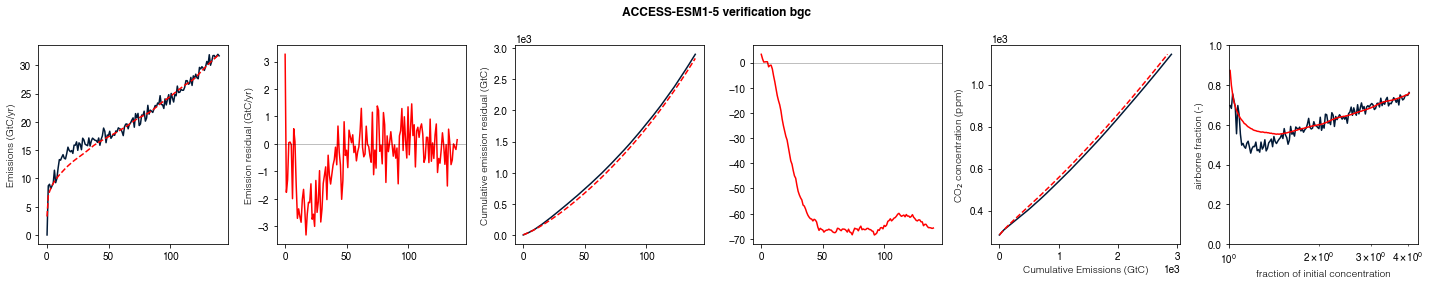

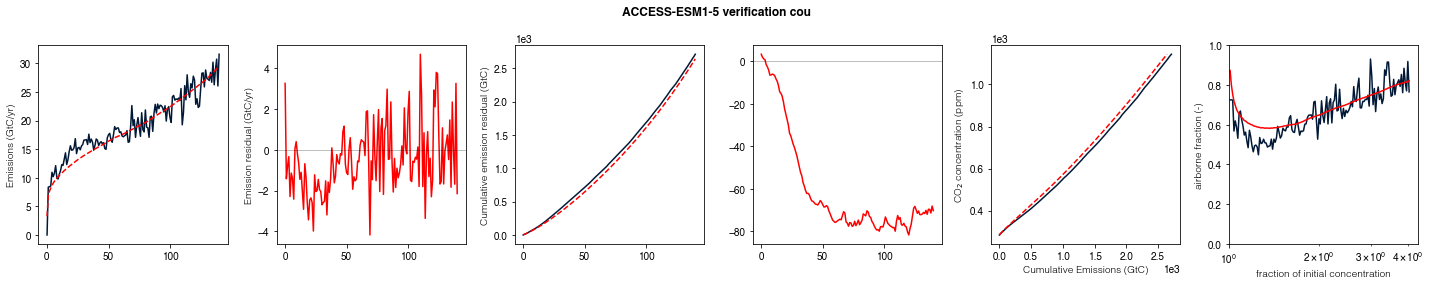

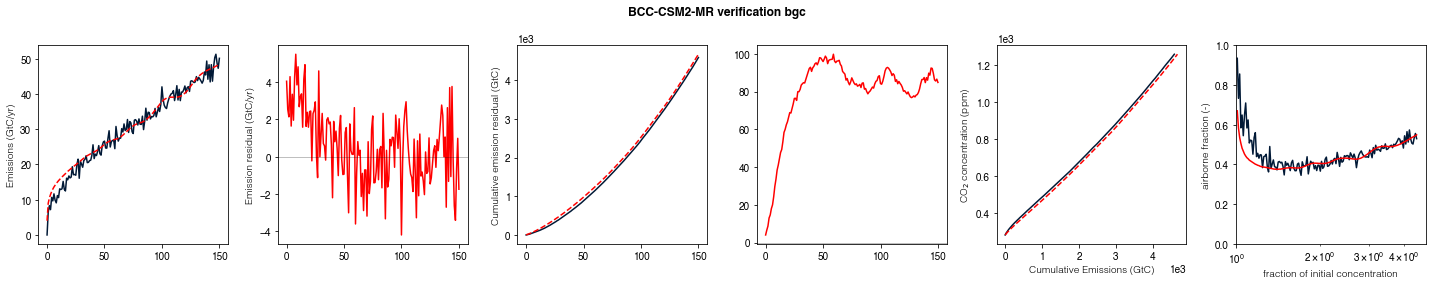

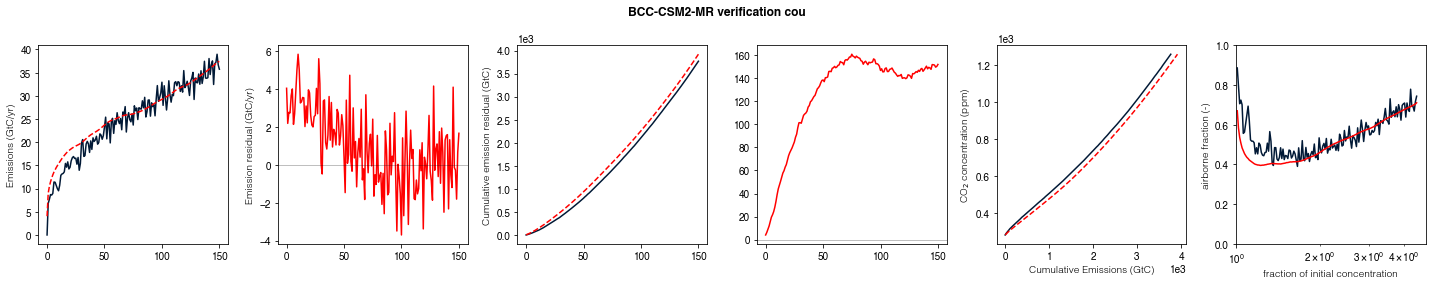

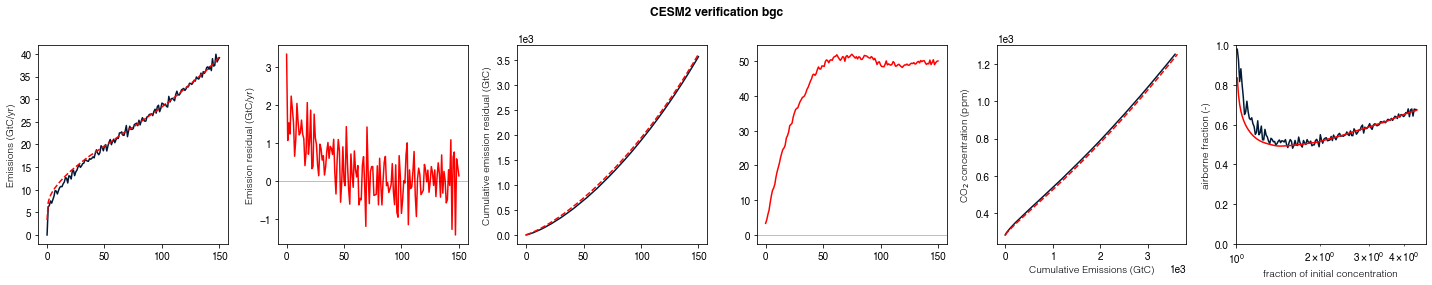

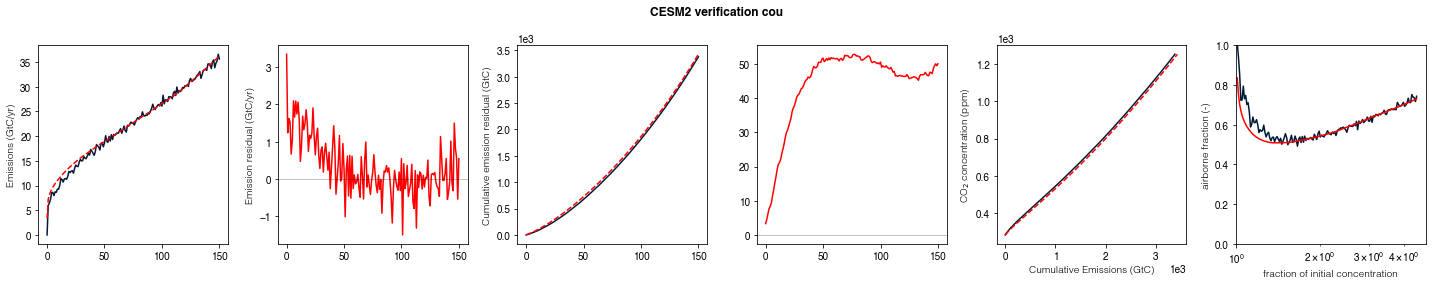

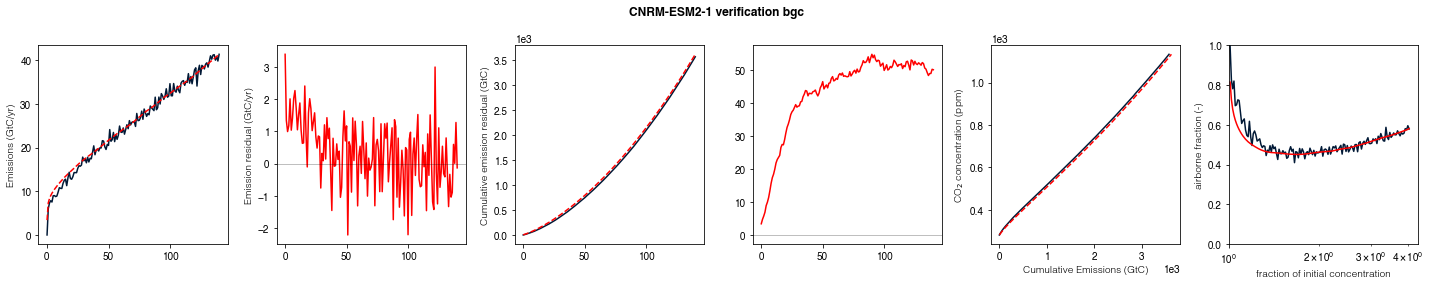

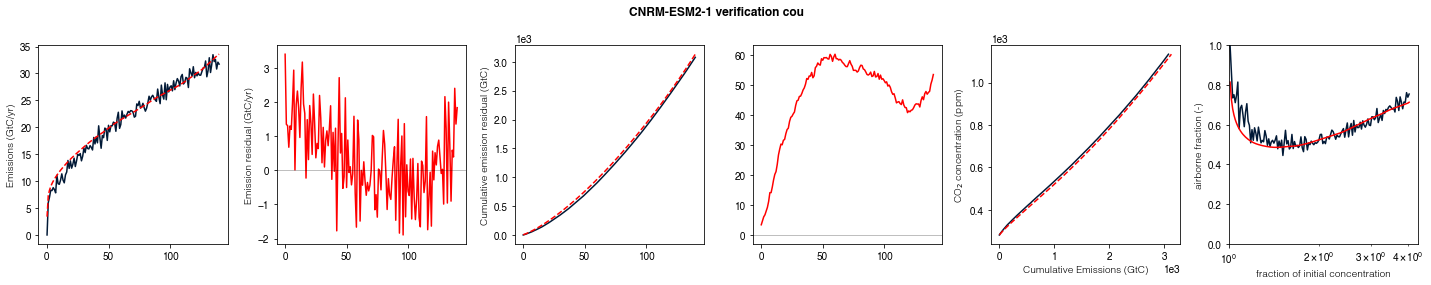

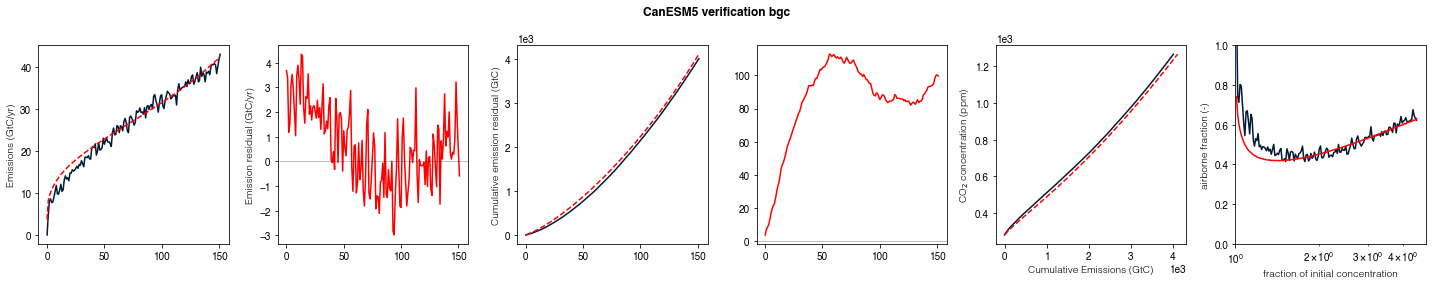

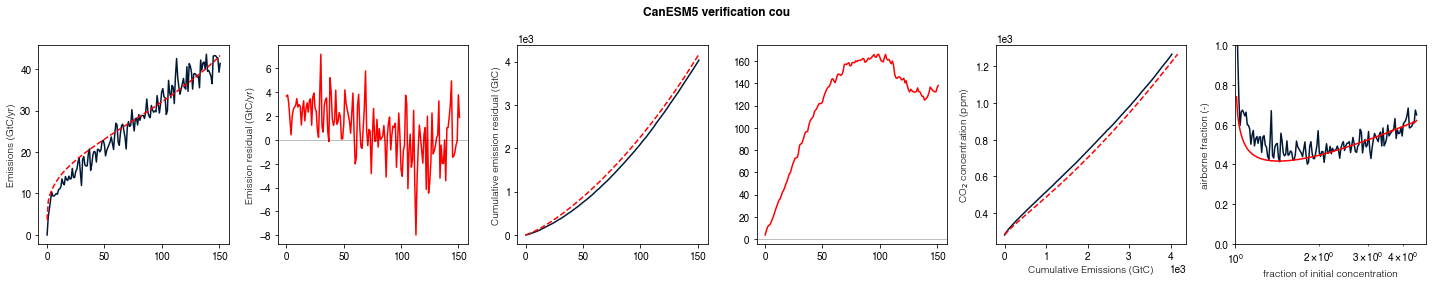

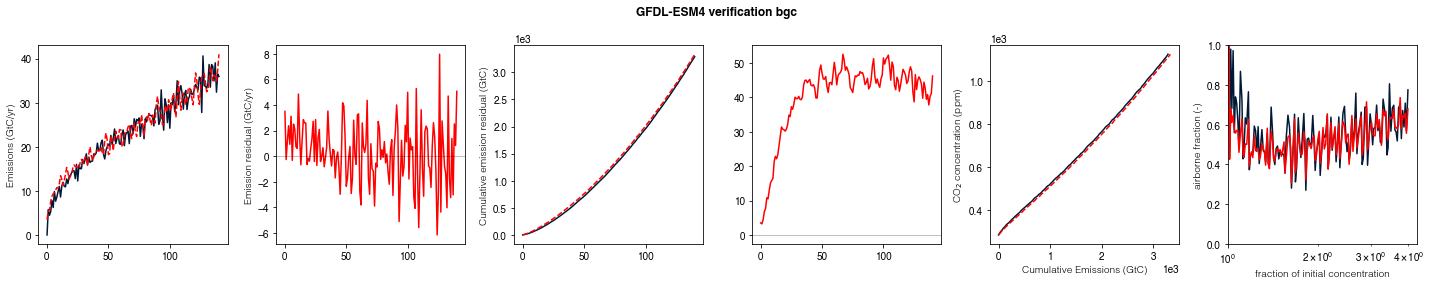

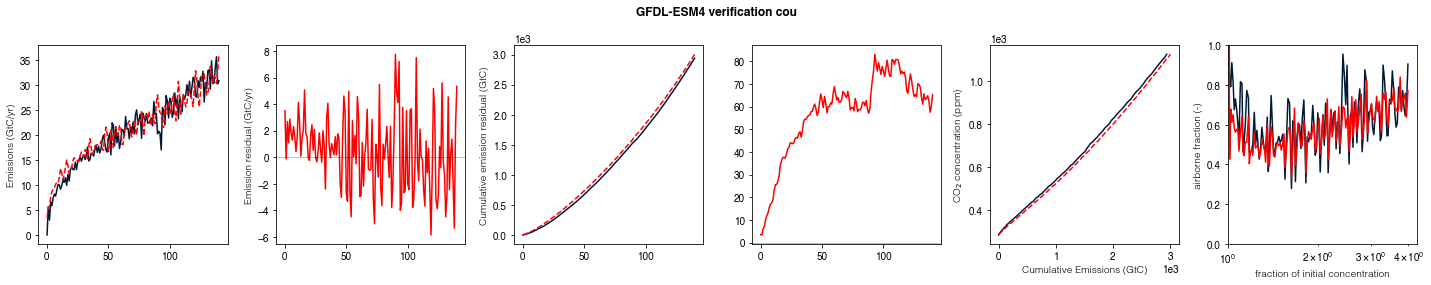

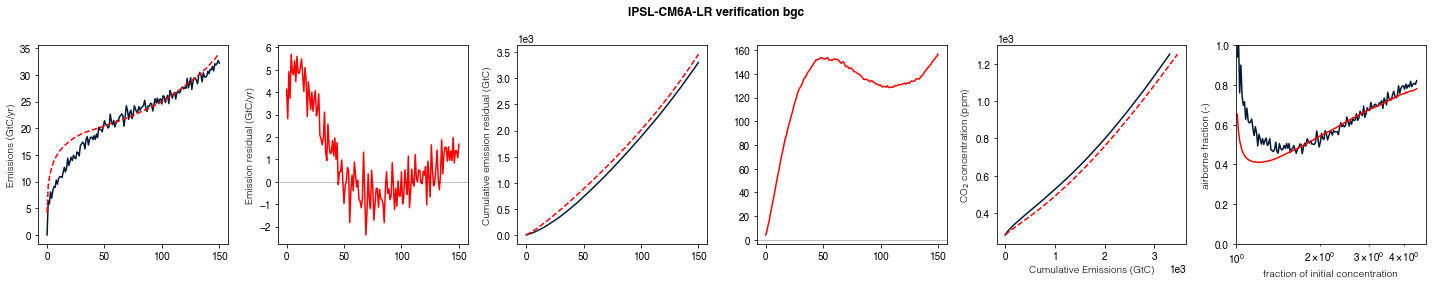

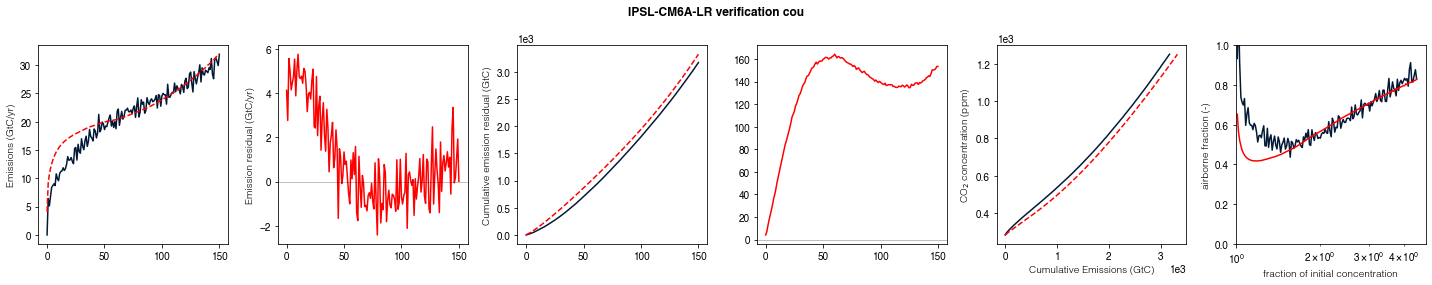

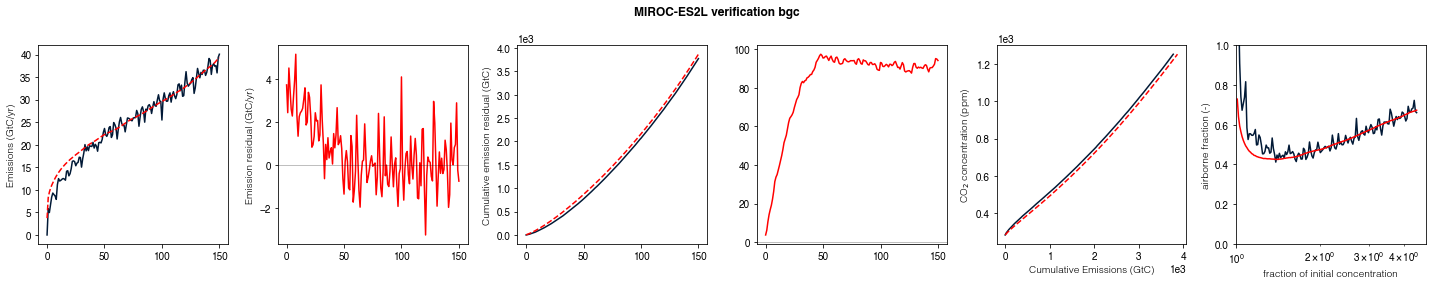

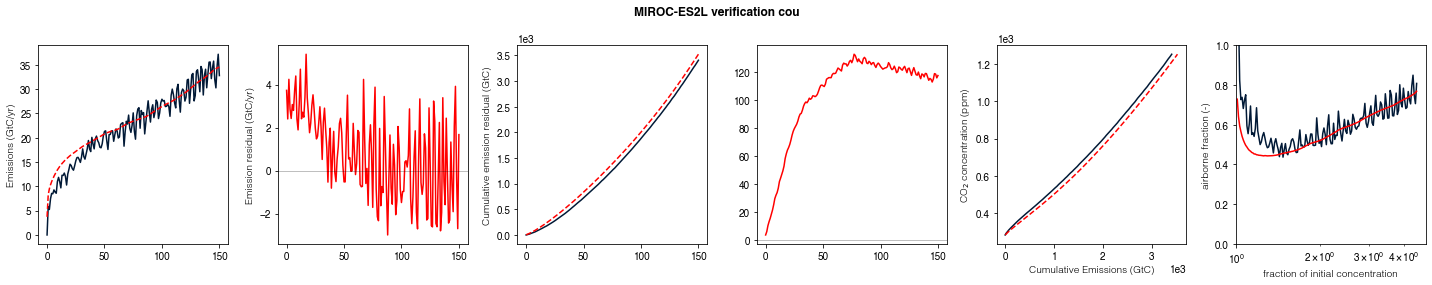

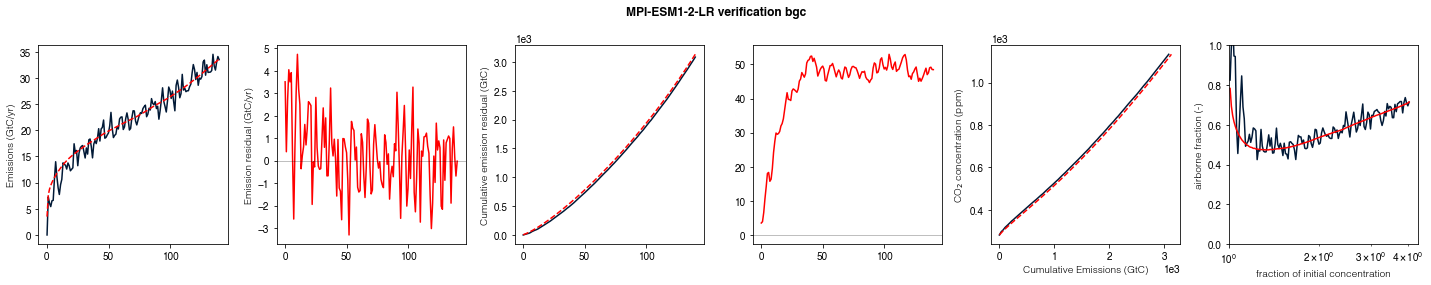

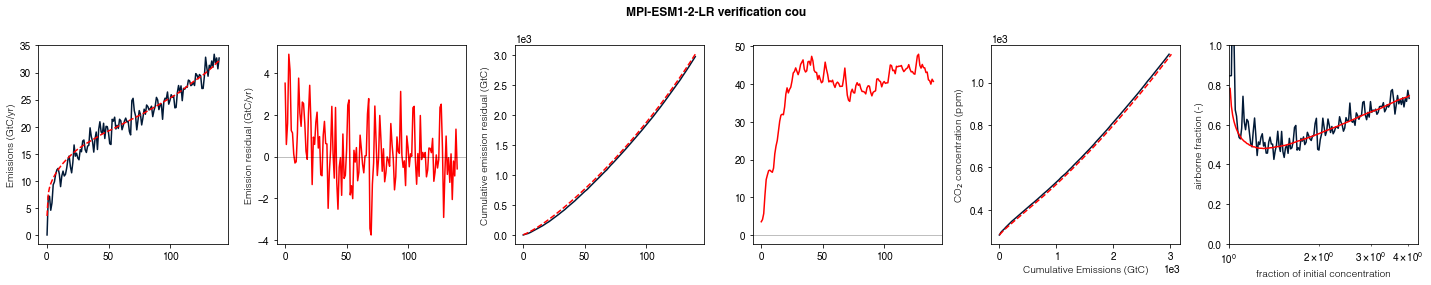

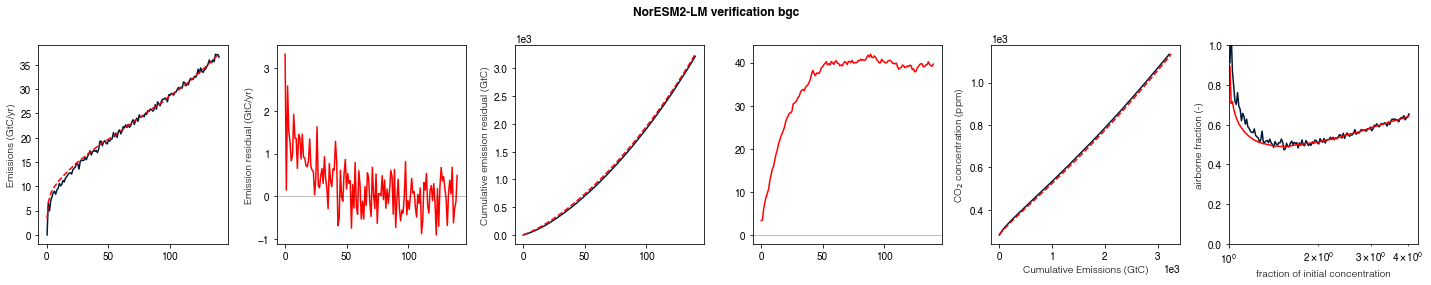

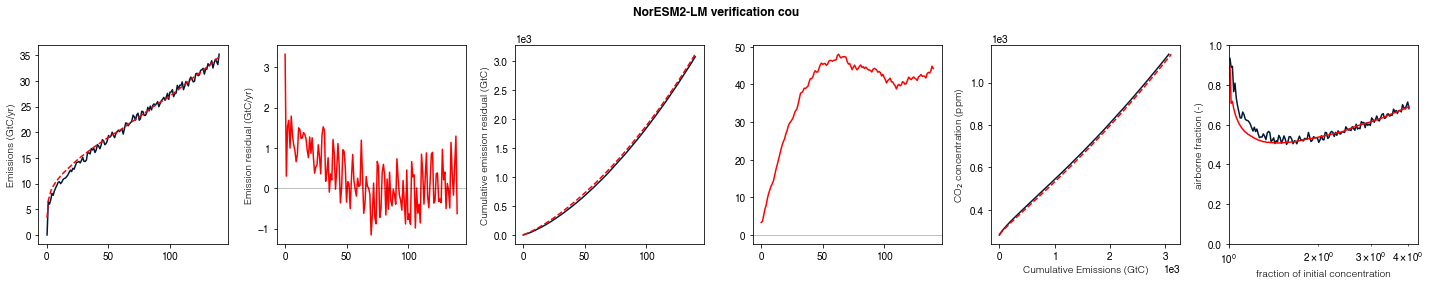

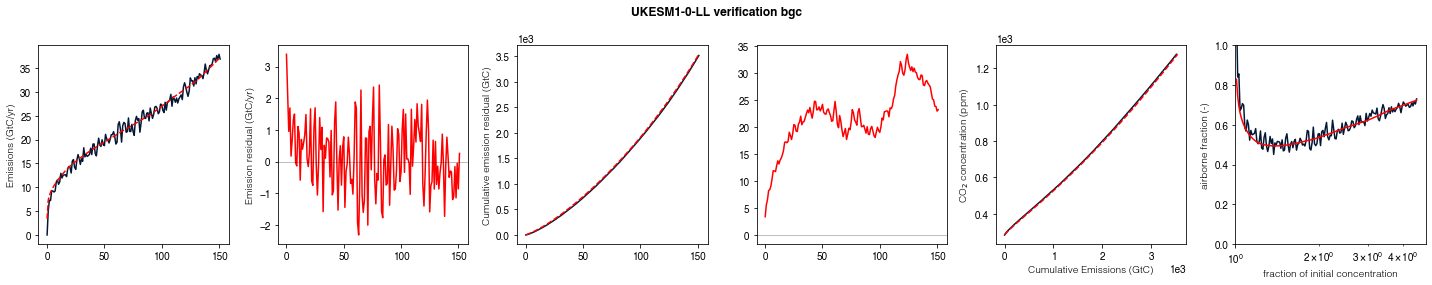

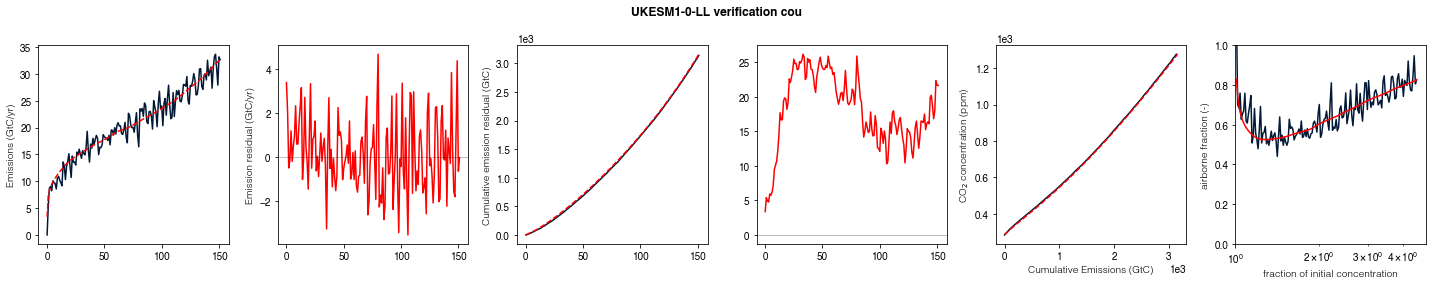

In [137]:
from pdfo import Bounds

cc_indep_tuning = pd.DataFrame(index=C4MIP_data_1.columns.levels[0],columns=['r0','rC','rT'])

## tune bgc simulations

model_cost_form = dict(zip(C4MIP_data_1.columns.levels[0],['rate_both','rate_cumulative','rate_cumulative','rate_both','rate_cumulative','rate_both','rate_both','rate_cumulative','rate_cumulative','rate_cumulative','rate_both']))

for model in C4MIP_data_1.columns.levels[0]:
    
    if model in ['GFDL-ESM4','CNRM-ESM2-1']: # GFDL tags on 10 years of flat concs at the end which screws with the fit / CNRM only has 139 years for some variables
        data_length = 139
    else:
        data_length=150

    atms_burden = pd.concat([(C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'CO2')].dropna()-C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'CO2')].dropna().iloc[0]/1.01)/4.688876e-01 for x in ['','-bgc','-rad']],axis=1)
    cum_emms = pd.concat([C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'flux')].dropna().cumsum() for x in ['','-bgc','-rad']],axis=1) + atms_burden.values
    concs = C4MIP_data_1.loc[:data_length,(model,'1pctCO2','CO2')].dropna()
    temps = pd.concat([C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'tas')].dropna()for x in ['','-bgc','-rad']],axis=1)
    
    b,w = sp.signal.butter(2,0.1)

    C = np.concatenate(([concs.iloc[0]/1.01],concs.values.astype(float)))
    T_bgc = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2-bgc','tas')].values.astype(float))))
    E_bgc = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')])))
    T_cou = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2','tas')].values.astype(float))))
    E_cou = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2','flux')])))

    lb = [20,-0.1,-10]
    ub = [45,0.1,10]
    bounds = Bounds(lb,ub)
    
    bgc_rate_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),C[0],C,T_bgc,E_bgc,cost='rate'),x0=[30,0.02,4],bounds=bounds,method='bobyqa',options={'npt':10}).fun
#     bgc_cum_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),x[3],C,T_bgc,E_bgc,cost='cumulative'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun
    cou_rate_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),C[0],C,T_cou,E_cou,cost='rate'),x0=[30,0.02,4],bounds=bounds,method='bobyqa',options={'npt':10}).fun
#     cou_cum_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),x[3],C,T_cou,E_cou,cost='cumulative'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun
    
#     bgc_rate_resvar_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),x[3],C,T_bgc,E_bgc,cost='rate_residual_variance'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun

    results = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),C[0],C,T_bgc,E_bgc,cost='rate',rate_weight=bgc_rate_weight,cum_weight=1)+tune_cc(np.array([x[0],x[1],x[2],0]),C[0],C,T_cou,E_cou,cost='rate',rate_weight=cou_rate_weight,cum_weight=1),x0=[30,0.02,4],bounds=bounds,method='bobyqa',options={'npt':10})
    
    fig,ax = plt.subplots(1,6,figsize=(20,4))
    r_verify = np.array([results.x[0],results.x[1],results.x[2],0])
    verify_tuning(ax,C,T_bgc,E_bgc,r_verify,C[0],color='red')
    fig.suptitle(model+' verification bgc',fontweight='bold')
    plt.tight_layout()
    
    fig,ax = plt.subplots(1,6,figsize=(20,4))
    verify_tuning(ax,C,T_cou,E_cou,r_verify,C[0],color='red')
    fig.suptitle(model+' verification cou',fontweight='bold')
    
    cc_indep_tuning.loc[model,:] = results.x
    
    ## now we check against the fixed ratio tuning
    
#     lb = [20,0,270]
#     ub = [45,0.1,300]
#     bounds = Bounds(lb,ub)
    
#     resultsfixed = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[1]*4.165/0.019,0]),x[2],C,T_cou,E_cou,cost='rate'),x0=[30,0.019,280],bounds=bounds,method='bobyqa',options={'npt':10})
    
#     r_verify = np.array([resultsfixed.x[0],resultsfixed.x[1],resultsfixed.x[1]*4.165/0.019,0])
#     verify_tuning(ax,C,T_cou,E_cou,r_verify,resultsfixed.x[2],plot_over=False,color='blue')
#     ax[-1].plot([],[],'red',label='independent')
#     ax[-1].plot([],[],'blue',label='fixed ratio')
#     ax[-1].legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [26]:
# cc_indep_tuning.to_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_15082020_indep_rCrT.csv')

In [138]:
cc_indep_tuning

r0         rC        rT
ACCESS-ESM1-5  42.7903  0.0307138   2.92802
BCC-CSM2-MR     21.709   0.011071   5.67986
CESM2          38.2466  0.0177162   1.50492
CNRM-ESM2-1      36.04  0.0117418   3.32347
CanESM5        28.4602  0.0161783 -0.252235
GFDL-ESM4       33.342   0.018145   4.15139
IPSL-CM6A-LR        20  0.0403243   1.57732
MIROC-ES2L     27.4534  0.0208273   3.83594
MPI-ESM1-2-LR   32.703  0.0275613   1.50542
NorESM2-LM     38.9561  0.0168211   1.82261
UKESM1-0-LL    37.6028  0.0228849   2.85896

### diagnosing $\alpha$ for the CMIP6 models
- compute alpha based on the concentrations / emissions from the CMIP6 ensemble

In [20]:
## try plotting log (atms_burden) against emission rate to show the initial adjustment in the actual data (not the derived alpha parameter!)
for model in C4MIP_data_1.columns.levels[0]:
    for exp in ['1pctCO2'+x for x in ['','-bgc','-rad']]:
        burden = (C4MIP_data_1.loc[:,(model,exp,'CO2')] - C4MIP_data_1.loc[0,(model,exp,'CO2')]/1.01)/4.688876e-01
        emms = C4MIP_data_1.loc[:,(model,exp,'flux')].cumsum() + burden
        emms.loc[-1] = 0
        emms.sort_index(inplace=True)
        emms = emms.diff().loc[0:]
        burden_change = burden.copy()
        burden_change.loc[-1] = 0
        burden_change.sort_index(inplace=True)
        burden_change = burden_change.diff().loc[0:]
        C4MIP_data_1.loc[:,(model,exp,'burden')] = burden
        C4MIP_data_1.loc[:,(model,exp,'burden_change')] = burden_change
        C4MIP_data_1.loc[:,(model,exp,'emms')] = emms
        
C4MIP_data_1.sort_index(axis=1,inplace=True)

In [21]:
def calc_R(x,R_old,E,a,tau,dt=1):
    return a*E*x*tau*( 1- np.exp(-dt/(x*tau)) ) + R_old*np.exp(-dt/(x*tau))

In [22]:
dt = 5
alpha_df = pd.DataFrame(index=np.arange(dt,151,dt),columns= pd.MultiIndex.from_product([C4MIP_data_1.columns.levels[0],['1pctCO2','1pctCO2-bgc']]),dtype=float)

for exp in ['1pctCO2','1pctCO2-bgc']:
    for model in alpha_df.columns.levels[0]:
        atms_burden = (C4MIP_data_1.loc[:,(model,exp,'CO2')].dropna()-C4MIP_data_1.loc[:,(model,exp,'CO2')].dropna().iloc[0]/1.01)/4.688876e-01
        cum_emms = (C4MIP_data_1.loc[:,(model,exp,'flux')].cumsum() + atms_burden).dropna()
        emms = cum_emms.diff()
        emms.loc[0] = cum_emms.loc[0]
        
        R = np.zeros((emms.size//dt,4))

        alpha_df[(model,exp)].iloc[0] = sp.optimize.newton(lambda x: np.sum(calc_R(x,0,emms.loc[:dt-1].mean(),a,tau,dt)) - atms_burden.loc[dt-1],x0=0.1)
        R[0] = calc_R(alpha_df[(model,exp)].iloc[0],0,emms.loc[:dt-1].mean(),a,tau,dt)

        for t in np.arange(1,R.shape[0]):
            alpha_df[(model,exp)].iloc[t] = sp.optimize.newton(lambda x: np.sum(calc_R(x,R[t-1],emms.loc[t*dt:(t+1)*dt-1].mean(),a,tau,dt)) - atms_burden.loc[(t+1)*dt-1],x0=0.1)
            R[t] = calc_R(alpha_df[(model,exp)].iloc[t],R[t-1],emms.loc[t*dt:(t+1)*dt-1].mean(),a,tau,dt)

In [23]:
g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)

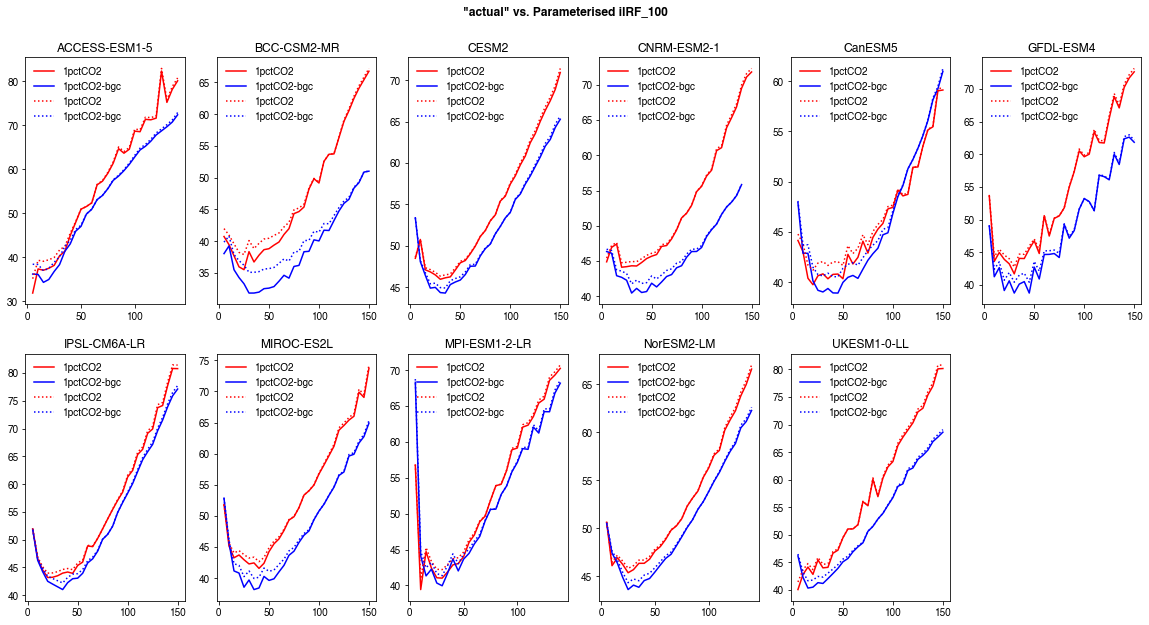

In [24]:
fig,ax = plt.subplots(2,6,figsize=(20,10))
iIRF100_test = alpha_df.applymap(lambda x:np.sum(a*x*tau*(1-np.exp(-100/(x*tau))),axis=-1))
g1_exp = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
g0_exp = ( np.exp( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) )**(-1.)
iIRF100 = g1_exp*np.log(alpha_df/g0_exp)
for i,model in enumerate(alpha_df.columns.levels[0]):
    iIRF100[model].plot(ax=ax.flatten()[i],color=['r','b'])
    iIRF100_test[model].plot(ax=ax.flatten()[i],color=['r','b'],ls=':')
#     (cc_indep_tuning.loc[model,'r0'] + C4MIP_data_1.loc[:,(model,['1pctCO2','1pctCO2-bgc'],'tas')].droplevel(-1,axis=1) * cc_indep_tuning.loc[model,'rT'] + C4MIP_data_1.loc[:,(model,['1pctCO2','1pctCO2-bgc'],'flux')].cumsum().droplevel(-1,axis=1)  * cc_indep_tuning.loc[model,'rC']).droplevel(0,axis=1).rolling(5).mean().iloc[4::5].plot(ax=ax.flatten()[i],color=['r','b'],ls=':')
    
    ax.flatten()[i].set_title(model)
    
fig.patch.set_facecolor('white')

fig.suptitle('"actual" vs. Parameterised iIRF_100',fontweight='bold',y=0.95)

ax[-1,-1].set_visible(False)

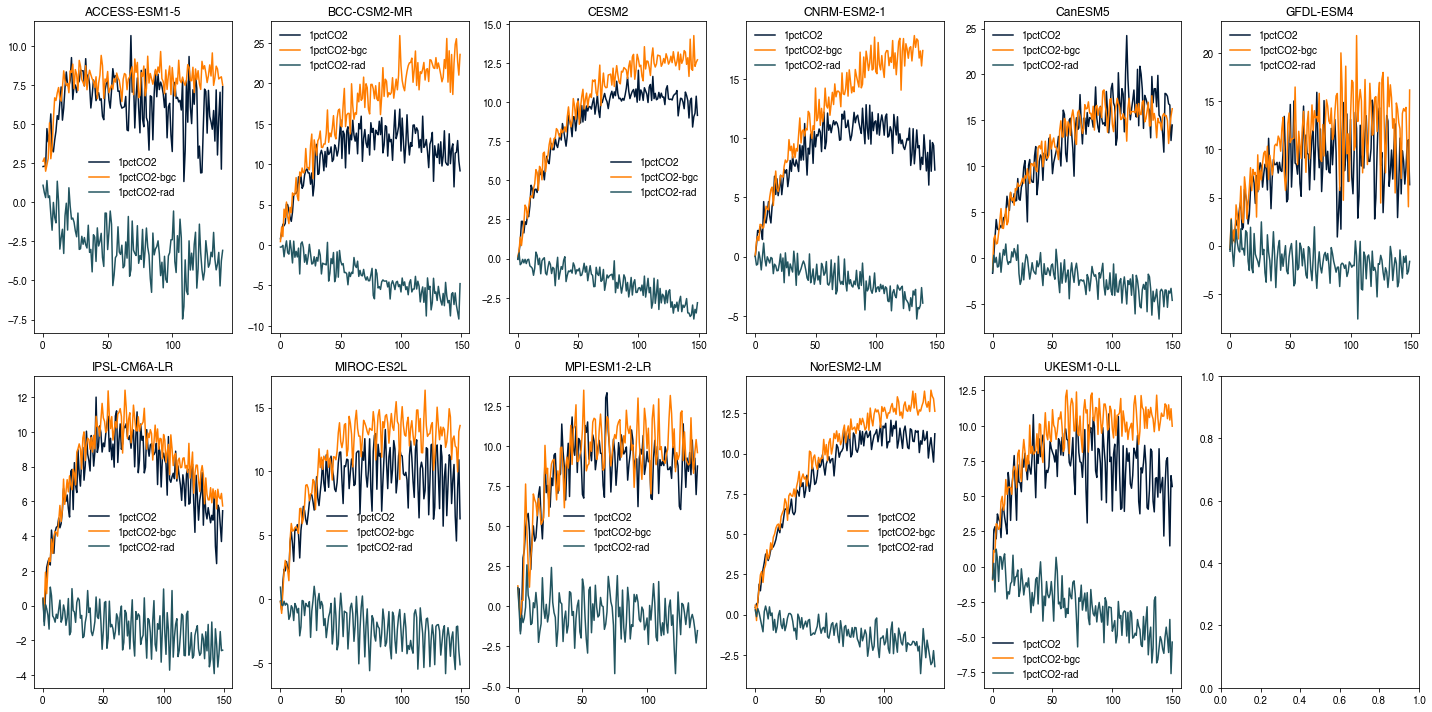

In [29]:
fig,ax = plt.subplots(2,6,figsize=(20,10))
for i,model in enumerate(alpha_df.columns.levels[0]):
    C4MIP_data_1[model].xs('flux',axis=1,level=-1).plot(ax=ax.flatten()[i])
    ax.flatten()[i].set_title(model)
    
plt.tight_layout()

In [35]:
model='GFDL-ESM4'
dt=5
test_alpha=np.zeros(30)
for exp in ['1pctCO2-bgc']:
    atms_burden = (C4MIP_data_1.loc[:,(model,exp,'CO2')].dropna()-C4MIP_data_1.loc[:,(model,exp,'CO2')].dropna().iloc[0]/1.01)/4.688876e-01
    cum_emms = C4MIP_data_1.loc[:,(model,exp,'flux')].dropna().cumsum() + atms_burden.values
    emms = cum_emms.diff()
    emms.loc[0] = cum_emms.loc[0]

    R = np.zeros((emms.size//dt,4))

    test_alpha[0] = sp.optimize.newton(lambda x: np.sum(calc_R(x,0,emms.loc[:dt-1].mean(),a,tau,dt)) - atms_burden.loc[dt-1],x0=0.1)
    R[0] = calc_R(test_alpha[0],0,emms.loc[:dt-1].mean(),a,tau,dt)

    for t in np.arange(1,R.shape[0]):
        test_alpha[t] = sp.optimize.newton(lambda x: np.sum(calc_R(x,R[t-1],emms.loc[t*dt:(t+1)*dt-1].mean(),a,tau,dt)) - atms_burden.loc[(t+1)*dt-1],x0=0.1)
        R[t] = calc_R(test_alpha[t],R[t-1],emms.loc[t*dt:(t+1)*dt-1].mean(),a,tau,dt)

Text(0.5, 1.0, 'GFDL-ESM4 diagnosed iIRF100')

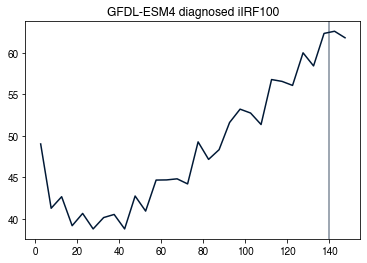

In [36]:
plt.plot(np.arange(2.5,148,5),np.arcsinh(test_alpha/g0)*g1)
plt.axvline(140,alpha=0.5)
plt.title('GFDL-ESM4 diagnosed iIRF100')

Text(0.5, 1.0, 'GFDL-ESM4 rate quantities')

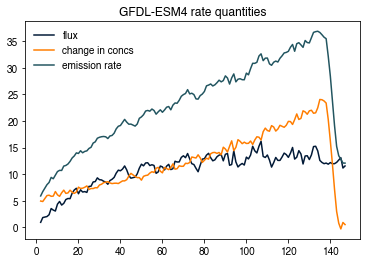

In [37]:
C4MIP_data_1.loc[:,('GFDL-ESM4','1pctCO2-bgc','flux')].rolling(5,center=True).mean().plot(label='flux')
C4MIP_data_1.loc[:,('GFDL-ESM4','1pctCO2-bgc','burden_change')].rolling(5,center=True).mean().plot(label='change in concs')
C4MIP_data_1.loc[:,('GFDL-ESM4','1pctCO2-bgc','emms')].rolling(5,center=True).mean().plot(label='emission rate')
plt.legend()
plt.title('GFDL-ESM4 rate quantities')

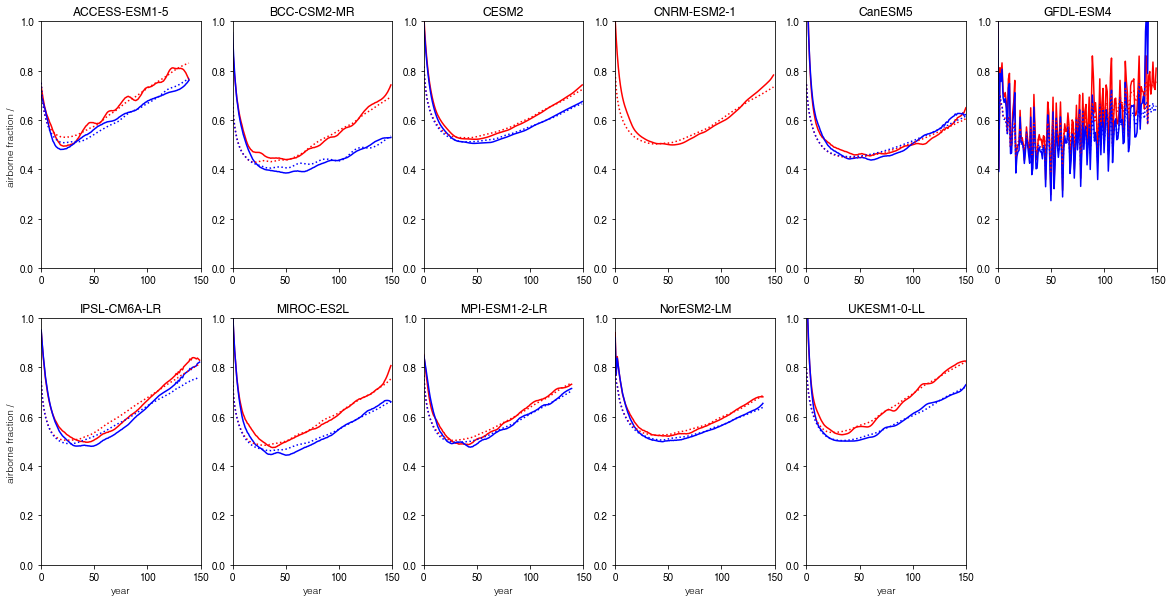

In [88]:

fig,ax = plt.subplots(2,6,figsize=(20,10))

for i,model in enumerate(cc_indep_tuning.index):
    
    atms_burden = pd.concat([(C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'CO2')].dropna()-C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'CO2')].dropna().iloc[0]/1.01)/4.688876e-01 for x in ['','-bgc','-rad']],axis=1)
    cum_emms = pd.concat([C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'flux')].dropna().cumsum() for x in ['','-bgc','-rad']],axis=1) + atms_burden.values
    concs = C4MIP_data_1.loc[:data_length,(model,'1pctCO2','CO2')].dropna()
    temps = pd.concat([C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'tas')].dropna()for x in ['','-bgc','-rad']],axis=1)
    
    b,w = sp.signal.butter(2,0.1)

    C = np.concatenate(([concs.iloc[0]/1.01],concs.values.astype(float)))
    T_bgc = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2-bgc','tas')].values.astype(float))))
    E_bgc = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')])))
    T_cou = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2','tas')].values.astype(float))))
    E_cou = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2','flux')])))

    r = np.array([*cc_indep_tuning.loc[model].values,0])
    
    emissions = invert_carbon_cycle_prescribed_T(C,T_cou,a,tau,r,C[0]/1.01,emis2conc).rolling(2).mean()
    emissions.loc[0] = 0
    
    b,w = sp.signal.butter(2,0.1)
    
    ax.flatten()[i].plot(np.diff(C)/4.688876e-01/emissions.values[1:],c='red',ls=':')
    ax.flatten()[i].plot(np.diff(C)/4.688876e-01/sp.signal.filtfilt(b,w,E_cou[1:]),zorder=0,c='red')
    
    emissions = invert_carbon_cycle_prescribed_T(C,T_bgc,a,tau,r,C[0]/1.01,emis2conc).rolling(2).mean()
    emissions.loc[0] = 0
    
    ax.flatten()[i].plot(np.diff(C)/4.688876e-01/emissions.values[1:],c='blue',ls=':')
    ax.flatten()[i].plot(np.diff(C)/4.688876e-01/sp.signal.filtfilt(b,w,E_bgc[1:]),zorder=0,c='blue')
    
    ax.flatten()[i].set_xlim(0,150)
    ax.flatten()[i].set_ylim(0,1)
    
    ax.flatten()[i].set_title(model)
    
[a.set_xlabel('year') for a in ax[1]]
[a.set_ylabel('airborne fraction / ') for a in ax[:,0]]
ax[-1,-1].set_visible(False)


## Parameterising on flux - not a good idea...

In [33]:
GIR_default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)['carbon_dioxide'].apply(pd.to_numeric)
a = GIR_default_params.loc['a1':'a4'].values
tau = GIR_default_params.loc['tau1':'tau4'].values
r = np.array([32.4,0.019,4.165,0])
PI_conc = GIR_default_params.loc['PI_conc']
emis2conc = GIR_default_params.loc['emis2conc']

def calculate_alpha_test(G,G_A,F,T,r,g0,g1,iirf100_max = False):

    iirf100_val = ne.evaluate("abs(r0 + rU * (G-G_A) + rT * T + rA * G_A + rF * F)",{'r0':r[...,0],'rU':r[...,1],'rT':r[...,2],'rA':r[...,3],'rF':r[...,4],'G':G,'G_A':G_A,'T':T,'F':F})
    if iirf100_max:
        iirf100_val = ne.evaluate("where(iirf100_val>iirf100_max,iirf100_max,iirf100_val)")
    alpha_val = ne.evaluate("g0 * sinh(iirf100_val / g1)")

    return alpha_val

def invert_carbon_cycle_prescribed_T_test(C,T,a,tau,r,PI_conc,emis2conc):
    
    g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ) )
    g0 = ( np.sinh( np.sum( a * tau * ( 1. - np.exp(-100/tau) ) ) / g1 ) )**(-1.)
    
    diagnosed_emissions = np.zeros(C.size)
    alpha = np.zeros(C.size)
    G_A = (np.array([np.mean(C[i:i+2]) for i in np.arange(C.size)])-PI_conc)/emis2conc
    G_A[-1]=2*G_A[-1]-G_A[-2]
    
    alpha[0] = calculate_alpha_test(G=0,G_A=0,F=0,T=0,r=r,g0=g0,g1=g1)
    diagnosed_emissions[0],R = unstep_concentration(R_old=0,G_A=G_A[0],alpha=alpha[0,np.newaxis],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc)
    F = diagnosed_emissions[0] - G_A[0]
    for t in np.arange(1,C.size):
        G = np.sum(diagnosed_emissions)
        alpha[t] = calculate_alpha_test(G=G,G_A=G_A[t-1],F=F,T=T[t-1],r=r,g0=g0,g1=g1)
        diagnosed_emissions[t],R = unstep_concentration(R_old=R,G_A=G_A[t],alpha=alpha[t,np.newaxis],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc)
        F = diagnosed_emissions[t] - (G_A[t]-G_A[t-1])
            
    return pd.Series(index=np.arange(C.size),data=diagnosed_emissions)

def tune_cc(r,PI_conc,C,T,E,cost='both',rate_weight=1,cum_weight=1):
    emissions = invert_carbon_cycle_prescribed_T_test(C,T,a,tau,r,PI_conc,emis2conc)
    rate_res = (emissions.values[1:] - E[1:])#.rolling(20).mean().loc[[39,59,79,99,119,139]].values / abs(pd.Series(E)).sum()
    _yp = emissions.diff()
    _y = pd.Series(E).diff()
    cum_res = np.cumsum(emissions.values) - np.cumsum(E)
    
    cost1 = np.sqrt(np.mean(rate_res**2))/rate_weight
    cost2 = np.sqrt(np.mean(cum_res**2))/cum_weight
    
    if cost == 'both':
        return cost1+cost2#(np.sum(rate_res**2)/np.sum(E[1:]) + np.sum(cum_res**2)/np.sum(np.cumsum(E)))/2
    if cost == 'rate':
        return cost1#np.sum(rate_res**2)/np.sum(E[1:])
    if cost == 'rate_residual_variance':
        return np.var(cost1)/resvar_weight
    if cost == 'cumulative':
        return cost2#np.sum(cum_res**2)/np.sum(np.cumsum(E))

def verify_tuning(ax,C,T,E,r,PI_conc,plot_over=True,color='green'):
    
    emissions = invert_carbon_cycle_prescribed_T_test(C,T,a,tau,r,PI_conc,emis2conc)
    ax[0].plot(emissions.values,'--',c=color)
    ax[1].plot((emissions.values-E),c=color)
    ax[2].plot(emissions.cumsum().values,'--',c=color)
    ax[3].plot((emissions.cumsum().values-np.cumsum(E)),zorder=0,c=color)
    ax[4].plot(emissions.cumsum().values,C,'--',c=color)
    ax[5].semilogx(C[1:]/C[0],np.diff(C)/4.688876e-01/emissions.values[1:],c=color)
    
    ax[5].set_xlim(xmin=1)
    ax[5].set_ylim(0,1)
    
    if plot_over:

        ax[0].plot(E,zorder=0)
        ax[2].plot(np.cumsum(E),zorder=0)
        ax[4].plot(np.cumsum(E),C,zorder=0)
        ax[5].semilogx(C[1:]/C[0],np.diff(C)/4.688876e-01/E[1:],zorder=0)
        ax[1].axhline(0,color='k',alpha=0.5,lw=0.5)
        ax[3].axhline(0,color='k',alpha=0.5,lw=0.5)

        ax[0].set_ylabel('Emissions (GtC/yr)')
        ax[1].set_ylabel('Emission residual (GtC/yr)')
        ax[2].set_ylabel('Cumulative Emissions (GtC)')
        ax[2].set_ylabel('Cumulative emission residual (GtC)')
        ax[4].set_xlabel('Cumulative Emissions (GtC)')
        ax[4].set_ylabel('CO$_2$ concentration (ppm)')
        ax[5].set_ylabel('airborne fraction (-)')
        ax[5].set_xlabel('fraction of initial concentration')

fit converged, r= [28.20900799  0.03634827  3.76751474  0.8758318 ]


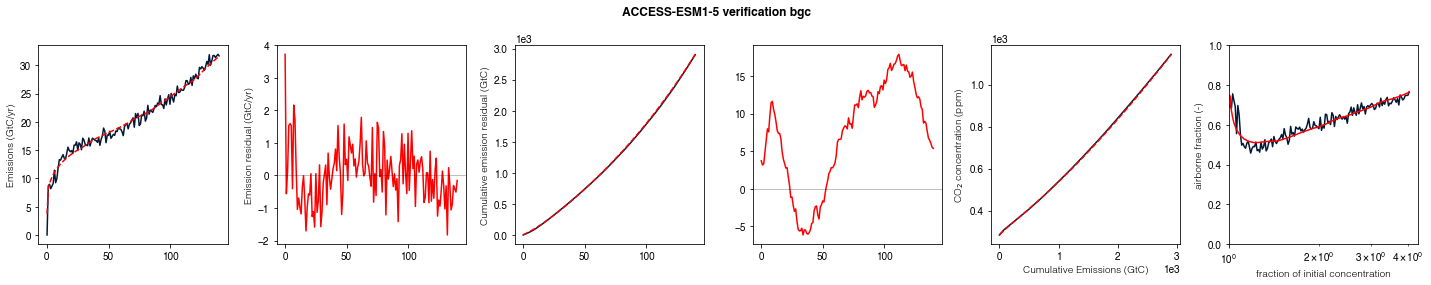

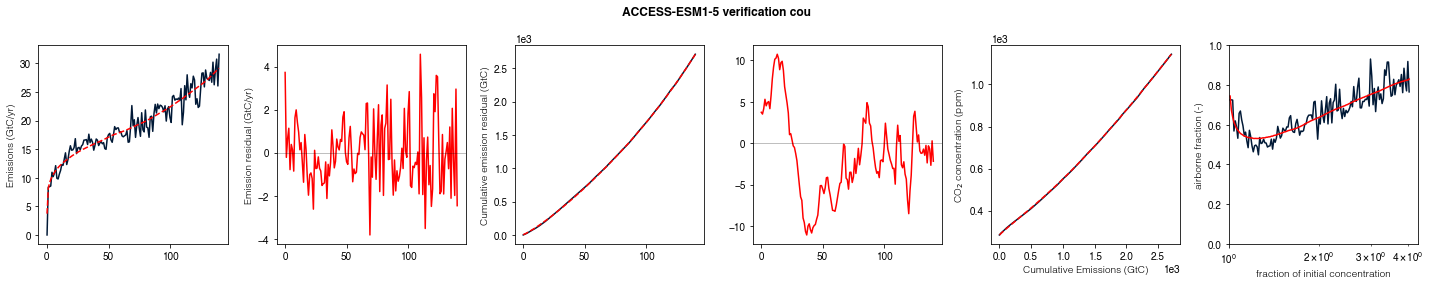

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)


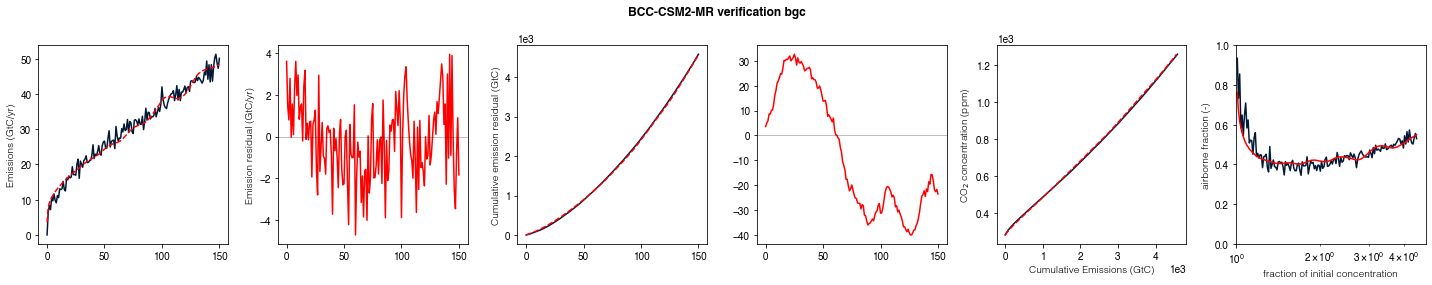

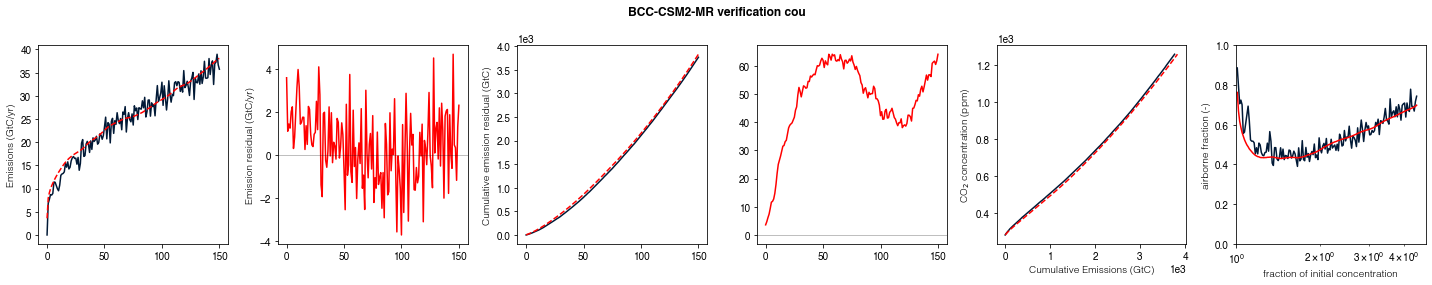

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)


fit converged, r= [3.05850027e+01 1.05186686e-02 4.04433670e+00 1.01617243e+00]


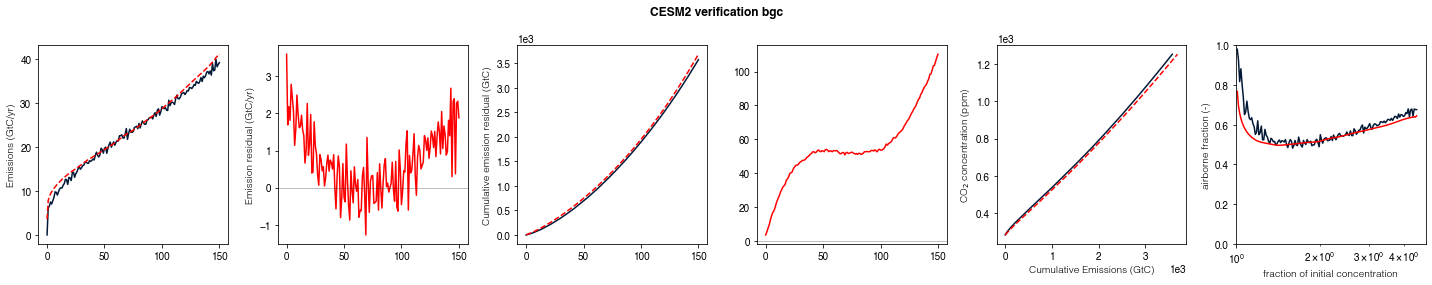

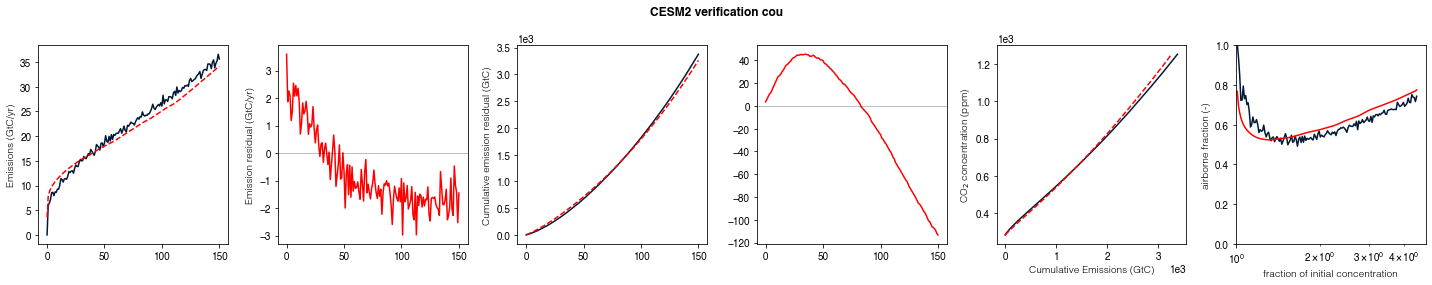

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)


fit converged, r= [3.05336336e+01 6.77476910e-03 4.19282091e+00 7.66615498e-01]


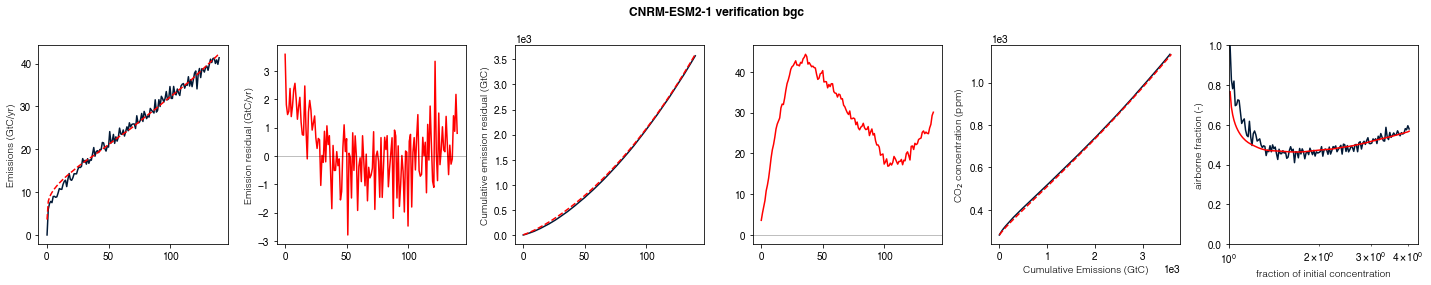

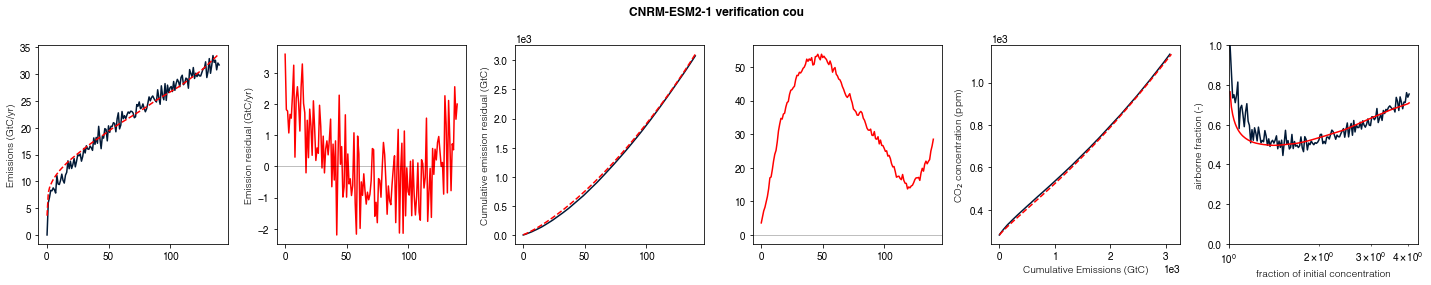

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)
../GIR.py:251: RuntimeWarning: divide by zero encountered in true_divide
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:251: RuntimeWarning: invalid value encountered in multiply
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))


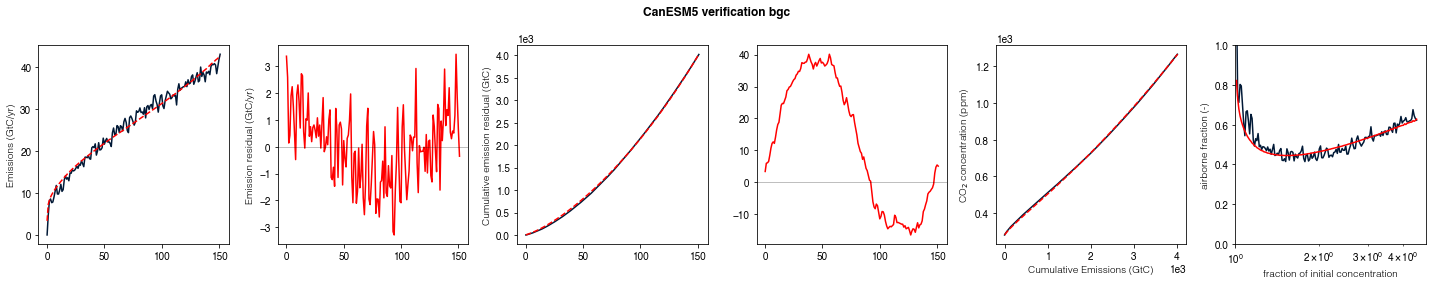

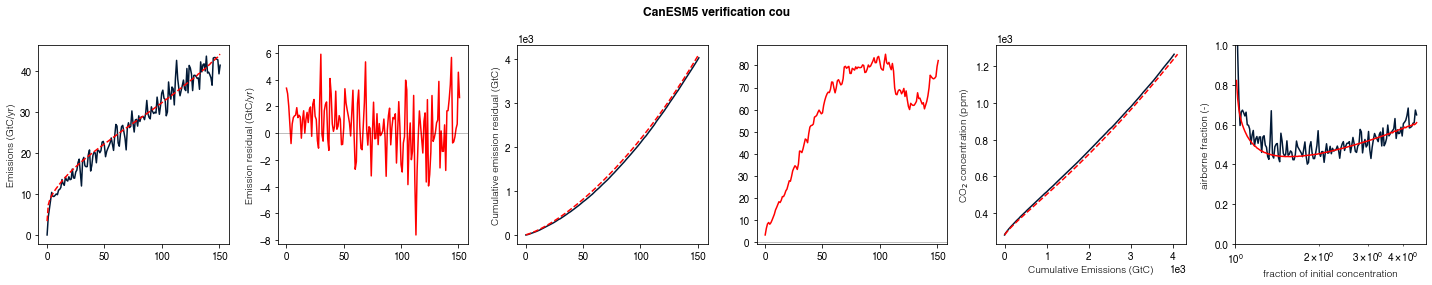

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)
../GIR.py:251: RuntimeWarning: divide by zero encountered in true_divide
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:251: RuntimeWarning: invalid value encountered in multiply
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))


fit converged, r= [ 4.41265089e+01  1.85719540e-02  3.26972293e+00 -7.76017024e-01]


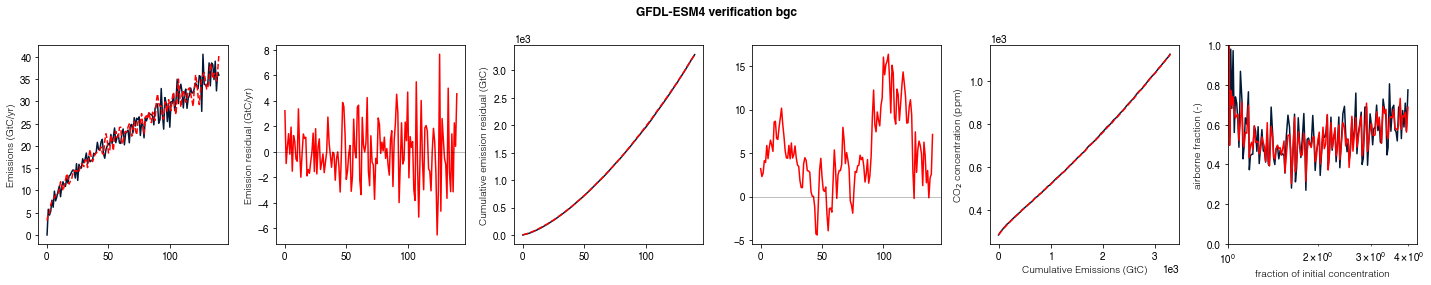

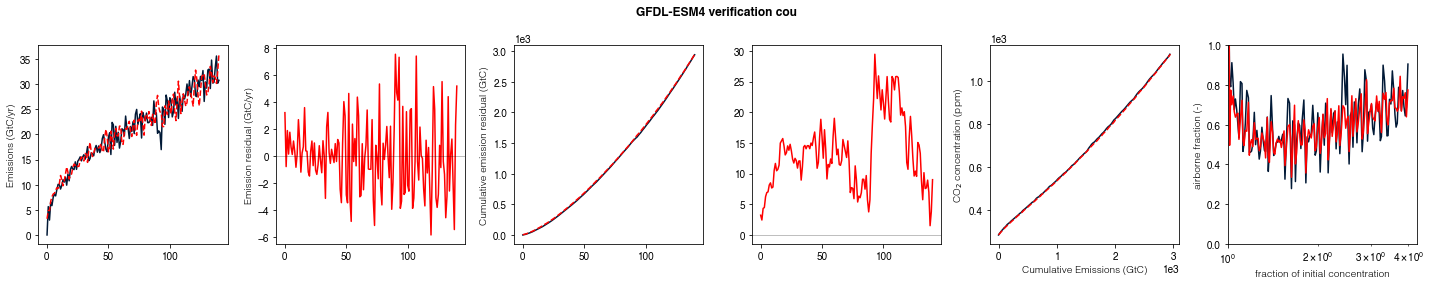

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)
../GIR.py:251: RuntimeWarning: divide by zero encountered in true_divide
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:251: RuntimeWarning: invalid value encountered in multiply
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))


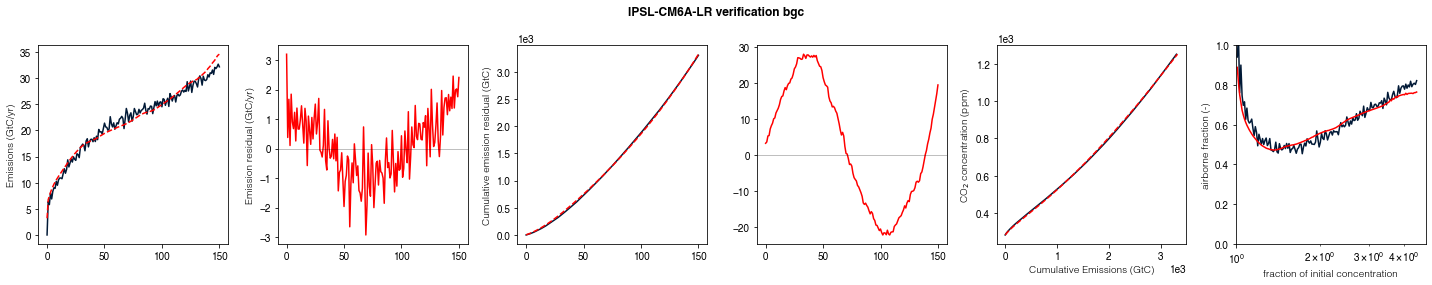

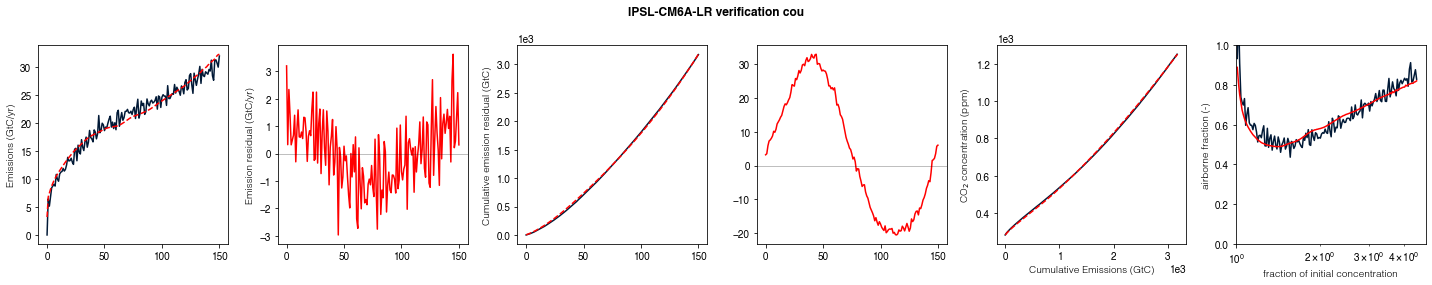

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
../GIR.py:251: RuntimeWarning: divide by zero encountered in true_divide
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:251: RuntimeWarning: invalid value encountered in multiply
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)


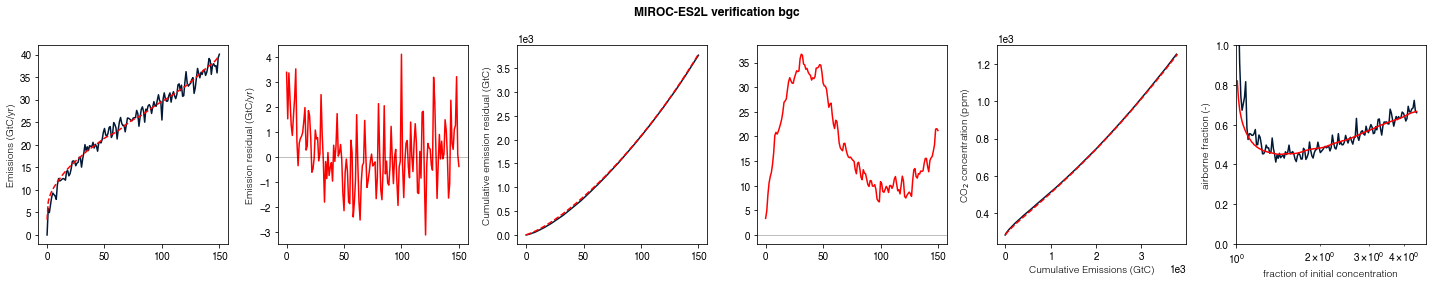

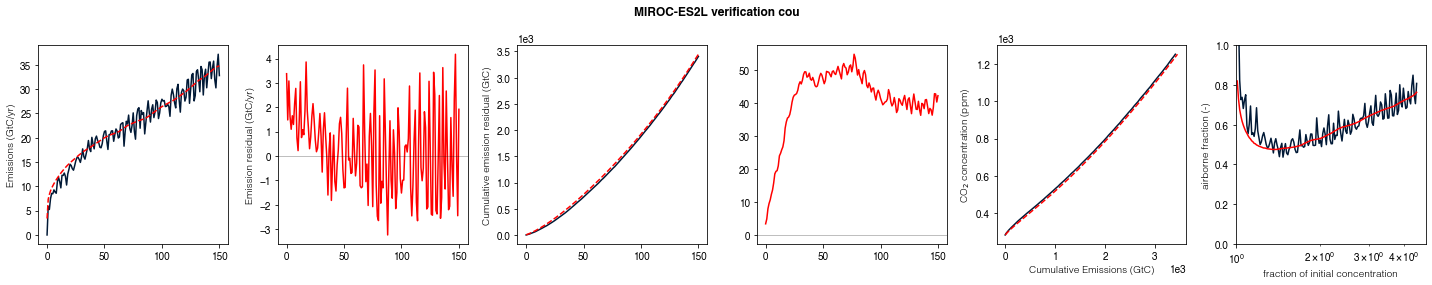

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)
../GIR.py:251: RuntimeWarning: divide by zero encountered in true_divide
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:251: RuntimeWarning: invalid value encountered in multiply
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))


fit converged, r= [ 4.50000000e+01  2.63257698e-02  1.05861002e+00 -9.74004584e-01]


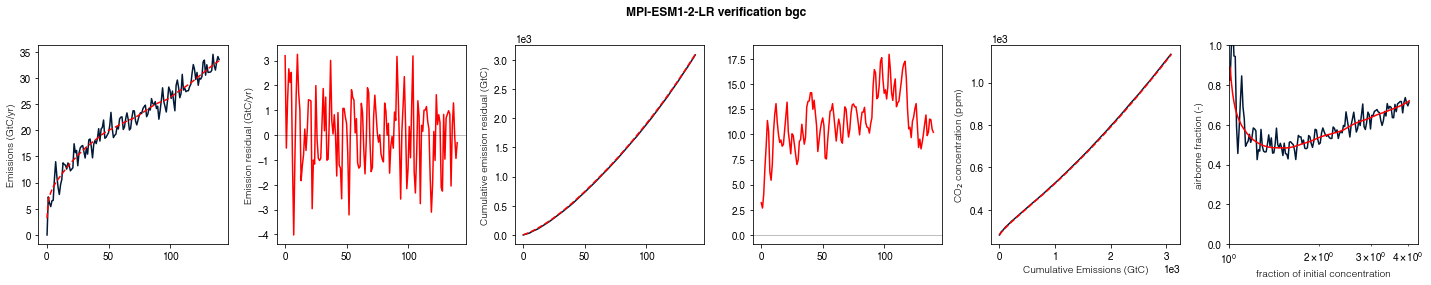

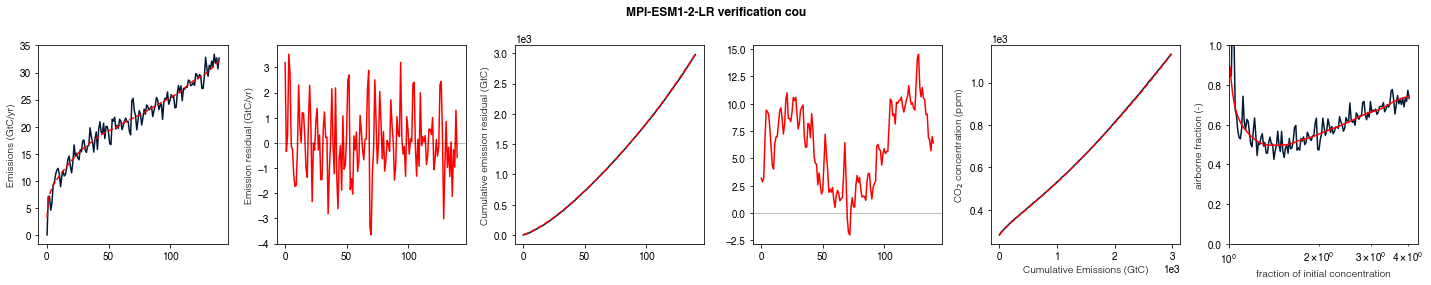

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)


fit converged, r= [3.01528360e+01 1.11926051e-02 3.84496956e+00 1.06422601e+00]


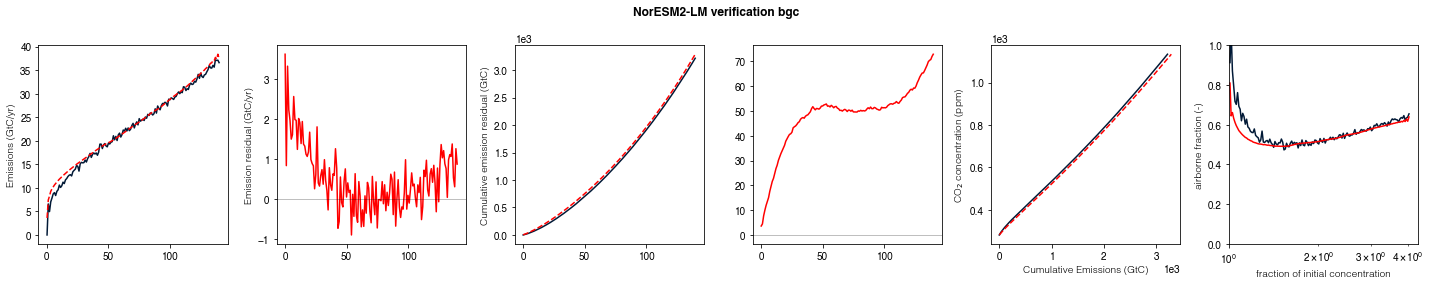

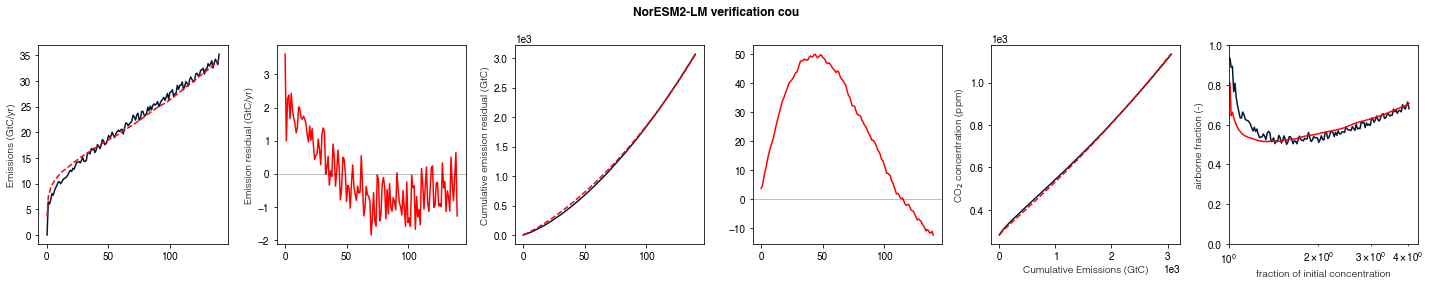

../GIR.py:251: RuntimeWarning: divide by zero encountered in double_scalars
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:252: RuntimeWarning: invalid value encountered in multiply
  R_new = E[...,None] * a * 1/decay_rate * ( 1. - decay_factor ) + R_old * decay_factor
/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2720: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1e+42 are replaced by hugefun.
  warnings.warn(warn_message, Warning)
../GIR.py:251: RuntimeWarning: divide by zero encountered in true_divide
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))
../GIR.py:251: RuntimeWarning: invalid value encountered in multiply
  E = (( G_A - np.sum(R_old*decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ) ,axis=-1 ))


fit converged, r= [ 4.21103861e+01  2.28029250e-02  2.57484008e+00 -3.77994373e-01]


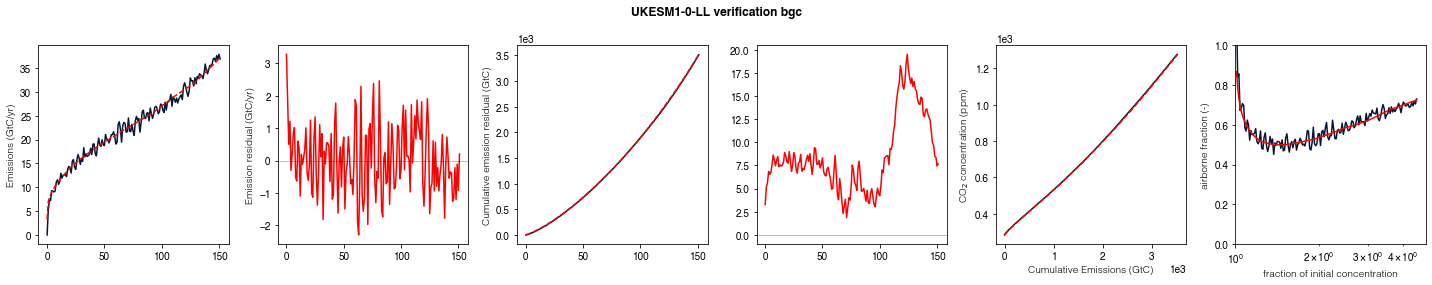

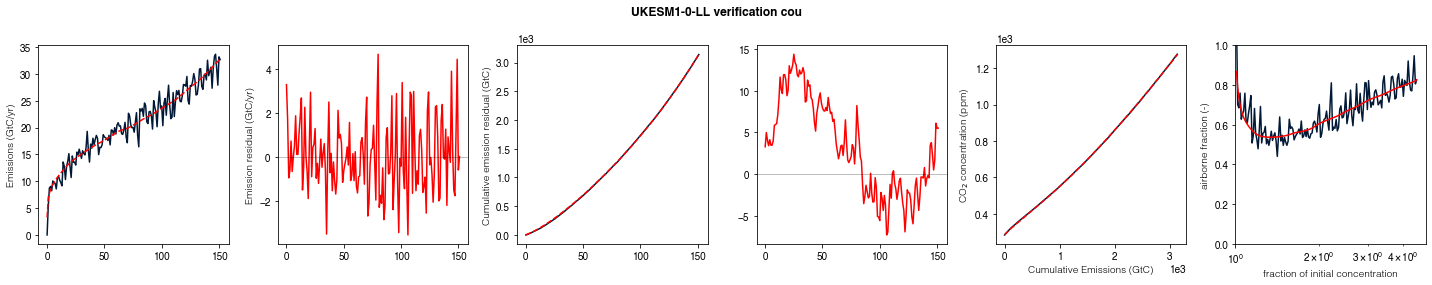

In [35]:
from pdfo import Bounds

cc_indep_tuning = pd.DataFrame(index=C4MIP_data_1.columns.levels[0],columns=['r0','rC','rT','rF'])

## tune bgc simulations

model_cost_form = dict(zip(C4MIP_data_1.columns.levels[0],['rate_both','rate_cumulative','rate_cumulative','rate_both','rate_cumulative','rate_both','rate_both','rate_cumulative','rate_cumulative','rate_cumulative','rate_both']))

for model in C4MIP_data_1.columns.levels[0]:
    
    if model in ['GFDL-ESM4','CNRM-ESM2-1']: # GFDL tags on 10 years of flat concs at the end which screws with the fit / CNRM only has 139 years for some variables
        data_length = 139
    else:
        data_length=150

    atms_burden = pd.concat([(C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'CO2')].dropna()-C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'CO2')].dropna().iloc[0]/1.01)/4.688876e-01 for x in ['','-bgc','-rad']],axis=1)
    cum_emms = pd.concat([C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'flux')].dropna().cumsum() for x in ['','-bgc','-rad']],axis=1) + atms_burden.values
    concs = C4MIP_data_1.loc[:data_length,(model,'1pctCO2','CO2')].dropna()
    temps = pd.concat([C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'tas')].dropna()for x in ['','-bgc','-rad']],axis=1)
    
    b,w = sp.signal.butter(2,0.1)

    C = np.concatenate(([concs.iloc[0]/1.01],concs.values.astype(float)))
    T_bgc = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2-bgc','tas')].values.astype(float))))
    E_bgc = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')])))
    T_cou = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2','tas')].values.astype(float))))
    E_cou = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2','flux')])))

    lb = [20,-0.1,-10,-10]
    ub = [45,0.1,10,10]
    bounds = Bounds(lb,ub)
    
    bgc_rate_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0,x[3]]),C[0],C,T_bgc,E_bgc,cost='rate'),x0=[30,0.02,4,-1],bounds=bounds,method='bobyqa',options={'npt':10}).fun
#     bgc_cum_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),x[3],C,T_bgc,E_bgc,cost='cumulative'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun
    cou_rate_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0,x[3]]),C[0],C,T_cou,E_cou,cost='rate'),x0=[30,0.02,4,-1],bounds=bounds,method='bobyqa',options={'npt':10}).fun
#     cou_cum_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),x[3],C,T_cou,E_cou,cost='cumulative'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun
    
#     bgc_rate_resvar_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),x[3],C,T_bgc,E_bgc,cost='rate_residual_variance'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun

    results = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0,x[3]]),C[0],C,T_bgc,E_bgc,cost='rate',rate_weight=bgc_rate_weight,cum_weight=1)+tune_cc(np.array([x[0],x[1],x[2],0,x[3]]),C[0],C,T_cou,E_cou,cost='rate',rate_weight=cou_rate_weight,cum_weight=1),x0=[30,0.02,4,-1],bounds=bounds,method='bobyqa',options={'npt':15})
    
    if results.success==1:
        print('fit converged, r=',results.x)
    
    fig,ax = plt.subplots(1,6,figsize=(20,4))
    r_verify = np.array([results.x[0],results.x[1],results.x[2],0,results.x[3]])
    verify_tuning(ax,C,T_bgc,E_bgc,r_verify,C[0],color='red')
    fig.suptitle(model+' verification bgc',fontweight='bold')
    plt.tight_layout()
    
    fig,ax = plt.subplots(1,6,figsize=(20,4))
    verify_tuning(ax,C,T_cou,E_cou,r_verify,C[0],color='red')
    fig.suptitle(model+' verification cou',fontweight='bold')
    
    cc_indep_tuning.loc[model,:] = results.x
    
    ## now we check against the fixed ratio tuning
    
#     lb = [20,0,270]
#     ub = [45,0.1,300]
#     bounds = Bounds(lb,ub)
    
#     resultsfixed = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[1]*4.165/0.019,0]),x[2],C,T_cou,E_cou,cost='rate'),x0=[30,0.019,280],bounds=bounds,method='bobyqa',options={'npt':10})
    
#     r_verify = np.array([resultsfixed.x[0],resultsfixed.x[1],resultsfixed.x[1]*4.165/0.019,0])
#     verify_tuning(ax,C,T_cou,E_cou,r_verify,resultsfixed.x[2],plot_over=False,color='blue')
#     ax[-1].plot([],[],'red',label='independent')
#     ax[-1].plot([],[],'blue',label='fixed ratio')
#     ax[-1].legend(loc='lower right')
    plt.tight_layout()
    plt.show()

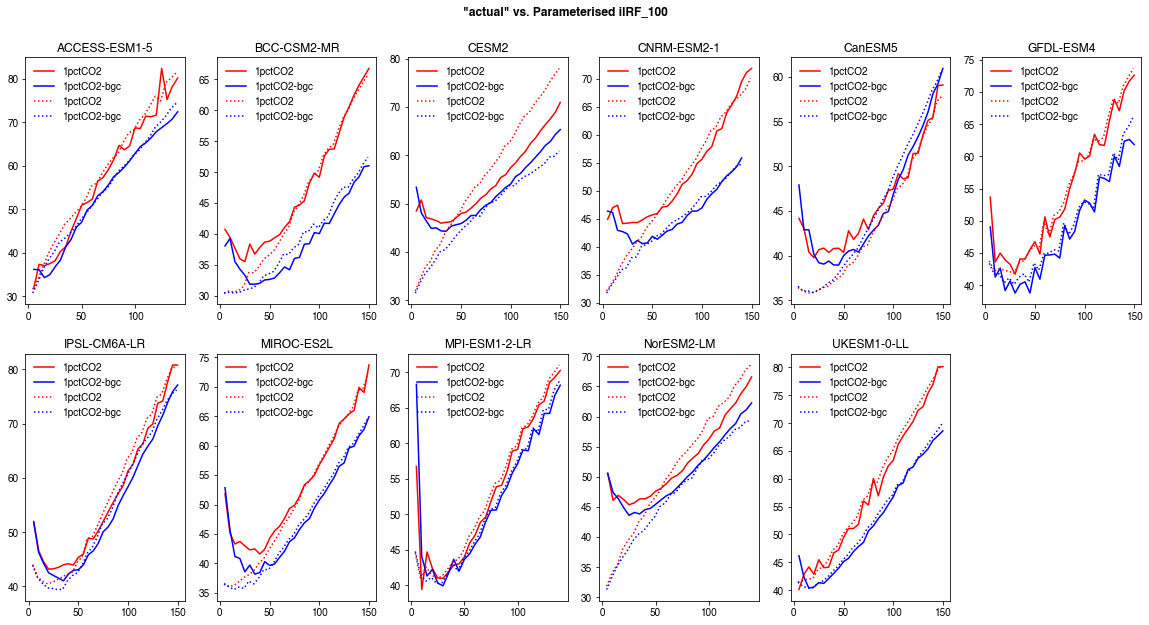

In [78]:
fig,ax = plt.subplots(2,6,figsize=(20,10))
for i,model in enumerate(alpha_df.columns.levels[0]):
    iIRF100[model].plot(ax=ax.flatten()[i],color=['r','b'])
    (cc_indep_tuning.loc[model,'r0'] + C4MIP_data_1.loc[:,(model,['1pctCO2','1pctCO2-bgc'],'tas')].droplevel(-1,axis=1) * cc_indep_tuning.loc[model,'rT'] + C4MIP_data_1.loc[:,(model,['1pctCO2','1pctCO2-bgc'],'flux')].cumsum().droplevel(-1,axis=1)  * cc_indep_tuning.loc[model,'rC'] + C4MIP_data_1.loc[:,(model,['1pctCO2','1pctCO2-bgc'],'flux')].droplevel(-1,axis=1)  * cc_indep_tuning.loc[model,'rF']).droplevel(0,axis=1).rolling(5).mean().iloc[4::5].plot(ax=ax.flatten()[i],color=['r','b'],ls=':')
    
    ax.flatten()[i].set_title(model)
    
fig.patch.set_facecolor('white')

fig.suptitle('"actual" vs. Parameterised iIRF_100',fontweight='bold',y=0.95)

ax[-1,-1].set_visible(False)

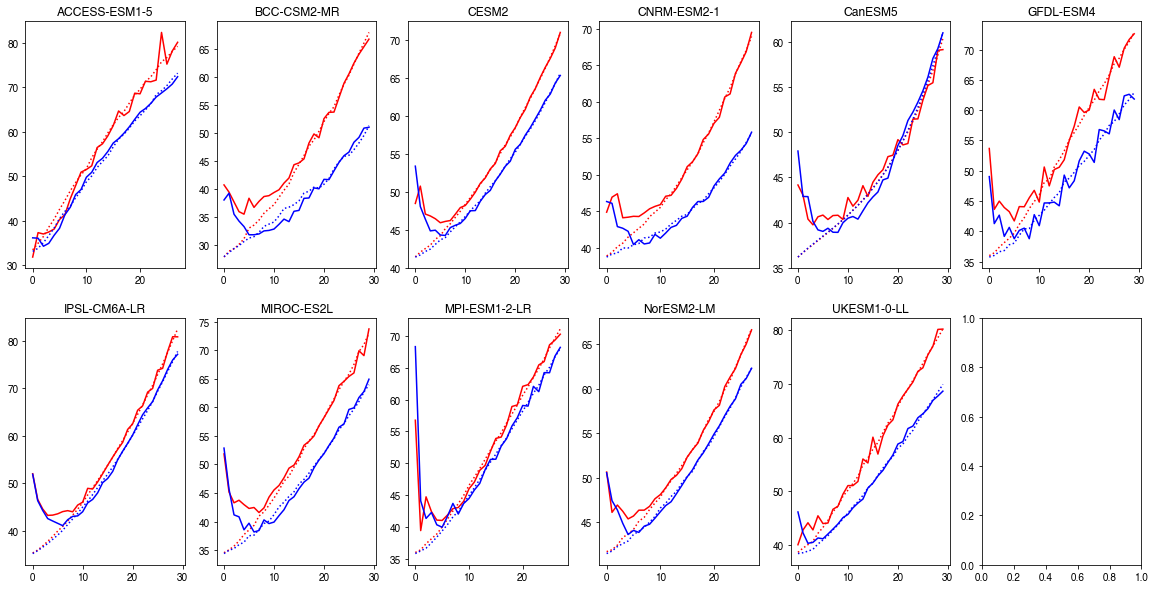

In [31]:
fig,ax = plt.subplots(2,6,figsize=(20,10))
exp=['1pctCO2','1pctCO2-bgc']
exp_color=dict(zip(exp,['r','b']))

cc_OLSE_results = pd.DataFrame(index=C4MIP_data_1.columns.levels[0],columns=['r0','rC','rT','rA','r0_err','rC_err','rT_err','rA_err'])

for i,model in enumerate(iIRF100.columns.levels[0]):

    iIRF100_mod = iIRF100[model].dropna()
    idxmin = iIRF100_mod.shape[0]-15
    flux_mod = C4MIP_data_1[model].loc[:iIRF100_mod.index[-1]].xs('flux',axis=1,level=-1)
    uptake_mod = flux_mod.cumsum()
    temp_mod = C4MIP_data_1[model].loc[:iIRF100_mod.index[-1]].xs('tas',axis=1,level=-1)
    CO2_mod = (C4MIP_data_1[model].loc[:iIRF100_mod.index[-1]].xs('CO2',axis=1,level=-1) - C4MIP_data_1[model].loc[0].xs('CO2',level=-1)/1.01)/0.4688875938875939

    flux_mod = flux_mod.rolling(5).mean().iloc[4::5]
    temp_mod = temp_mod.rolling(5).mean().iloc[4::5]
    uptake_mod = uptake_mod.rolling(5).mean().iloc[4::5]
    CO2_mod = CO2_mod.rolling(5).mean().iloc[4::5]

    _LR = OLSE_NORM(np.array([uptake_mod[exp].values.flatten(),temp_mod[exp].values.flatten(),CO2_mod[exp].values.flatten()]).T[idxmin:],iIRF100_mod.values.flatten()[idxmin:,None])

    for e in exp:
        ax.flatten()[i].plot(np.array([uptake_mod[e].values.flatten(),temp_mod[e].values.flatten(),CO2_mod[e].values.flatten()]).T.dot(_LR['coefs'])+_LR['intercept'],color=exp_color[e],ls=':')
        ax.flatten()[i].plot(iIRF100_mod[e].values,color=exp_color[e])
        
    cc_OLSE_results.loc[model] = np.array([_LR['intercept'],*_LR['coefs'],_LR['intercept_err']/_LR['intercept'],*(_LR['coef_err']/_LR['coefs'])]).flatten()
    
    
    ax.flatten()[i].set_title(model)

In [26]:
cc_OLSE_results['rC/rT'] = cc_OLSE_results.rT / cc_OLSE_results.rC

In [32]:
cc_OLSE_results

r0           rC        rT          rA      r0_err  \
ACCESS-ESM1-5   32.829    0.0481647   3.44493 -0.00627383   0.0354045   
BCC-CSM2-MR    27.6508   0.00158529   4.51959  0.00873033   0.0224367   
CESM2          41.3206   0.00751456   1.18889  0.00625699  0.00281237   
CNRM-ESM2-1     38.508 -0.000361861   2.44411   0.0103091  0.00485105   
CanESM5        35.8833   -0.0071168 -0.084697   0.0190813  0.00900749   
GFDL-ESM4      35.7606    0.0176544   4.50743  -0.0015594    0.020679   
IPSL-CM6A-LR   34.8436   0.00936086  0.934087   0.0155912   0.0110085   
MIROC-ES2L     34.3183    0.0104255   3.29273  0.00574216   0.0120636   
MPI-ESM1-2-LR  35.6926    0.0207715   1.26084   0.0035712   0.0107997   
NorESM2-LM     41.3227   0.00558968    1.4541  0.00756672  0.00257763   
UKESM1-0-LL    38.5428    0.0181093   2.58422  0.00286719   0.0112199   

                 rC_err     rT_err     rA_err  
ACCESS-ESM1-5  0.120404  0.0705117   -0.48359  
BCC-CSM2-MR     1.40032  0.0865367   0.303671  
CESM2          0.120181  0.0287859   0.106015  
CNRM-ESM2-1    -5.26111  0.0586524   0.181033  
CanESM5       -0.347144  -0.740819   0.126714  
GFDL-ESM4      0.231123  0.0925079    -2.1197  
IPSL-CM6A-LR   0.167851  0.0679965  0.0590015  
MIROC-ES2L     0.189323  0.0568314   0.280505  
MPI-ESM1-2-LR  0.118196  0.0786017   0.472895  
NorESM2-LM     0.223741  0.0410853   0.131185  
UKESM1-0-LL     0.11973  0.0421853   0.481453

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


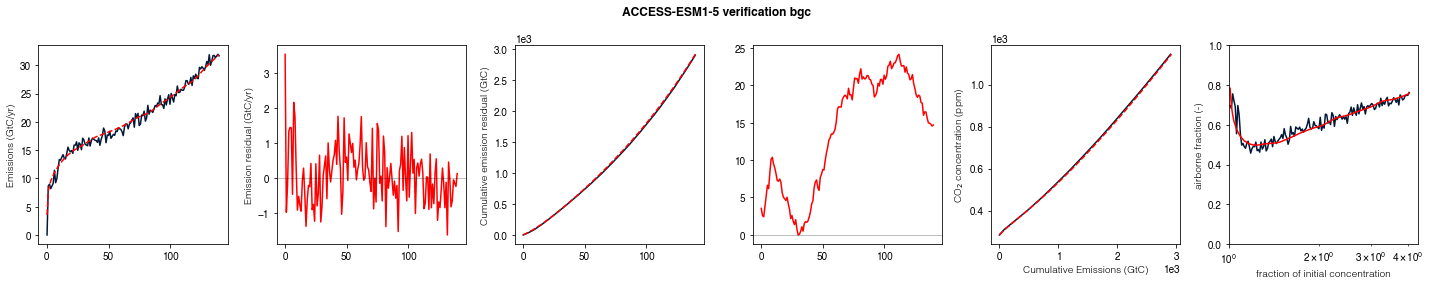

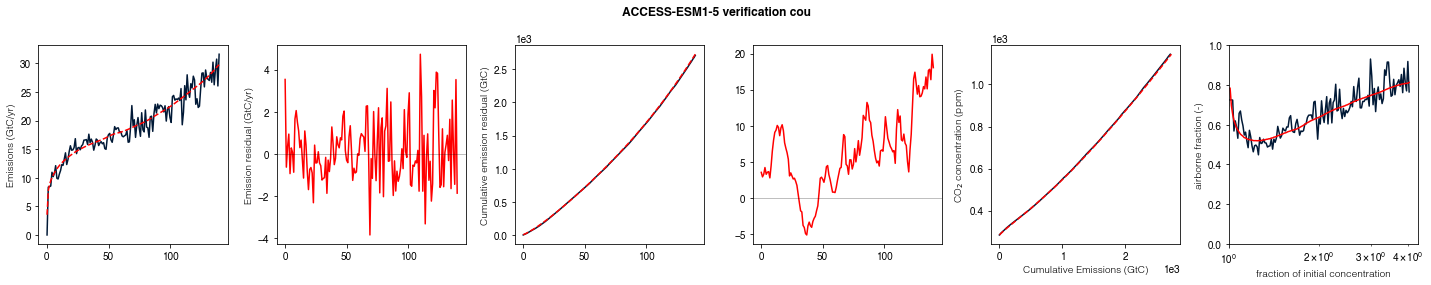

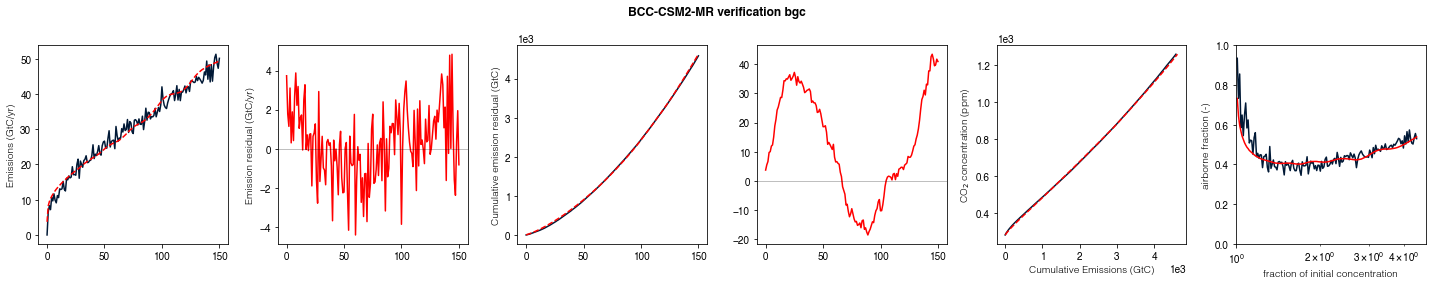

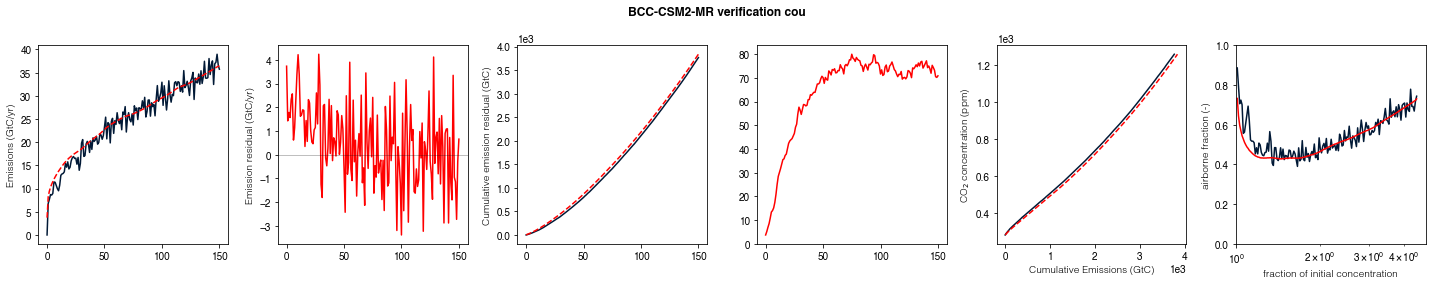

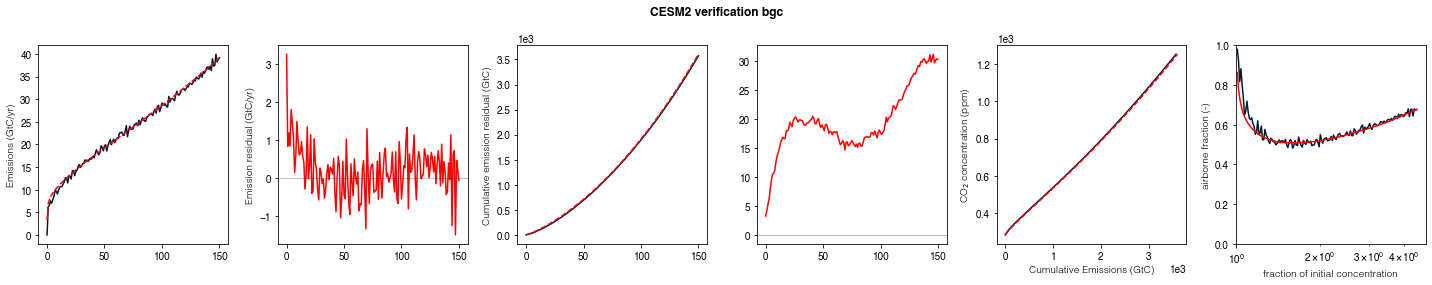

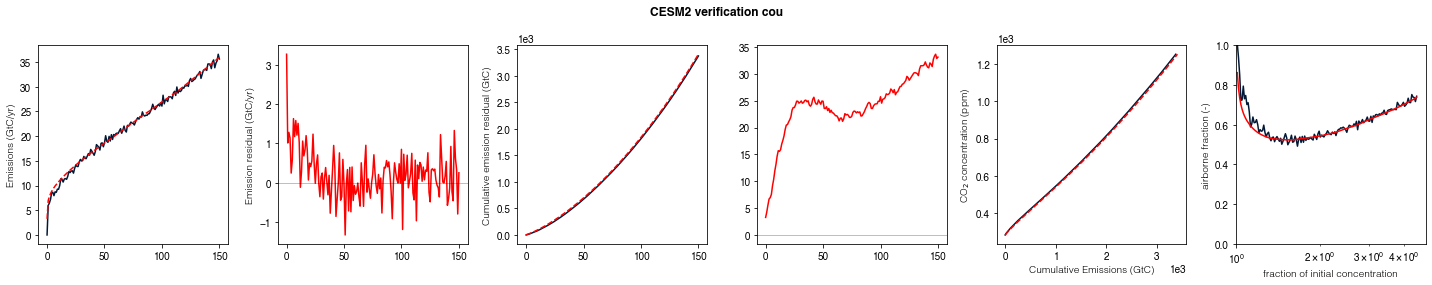

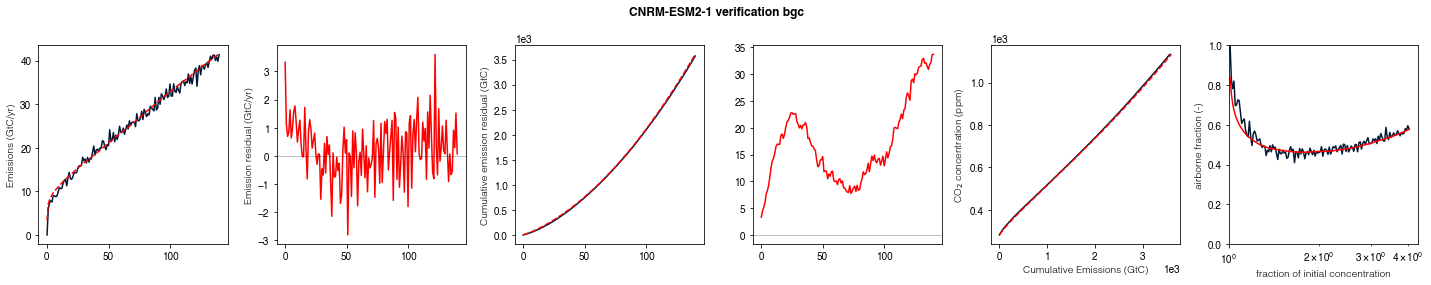

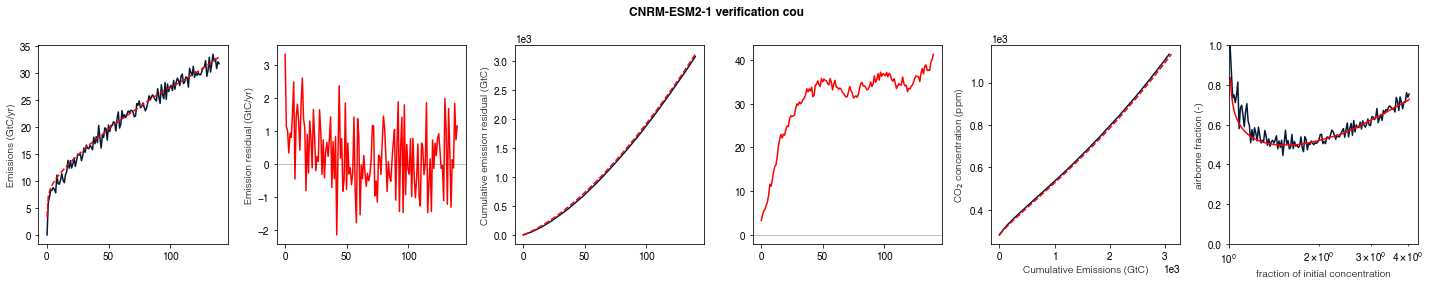

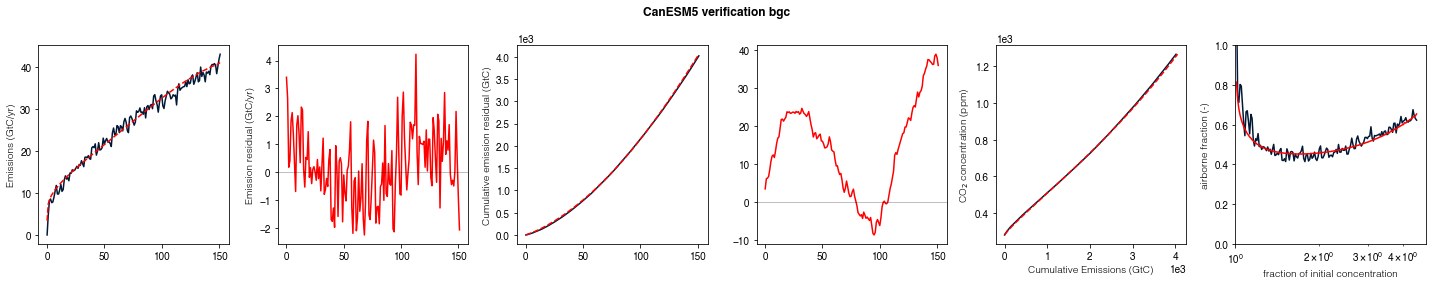

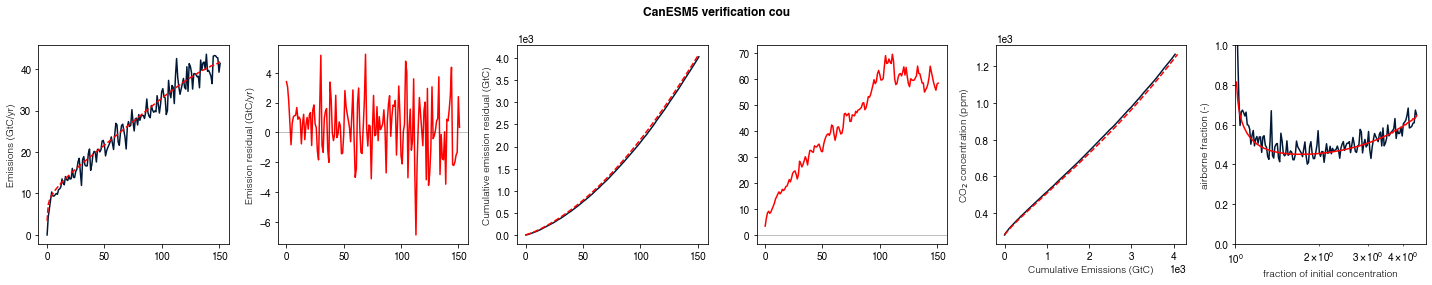

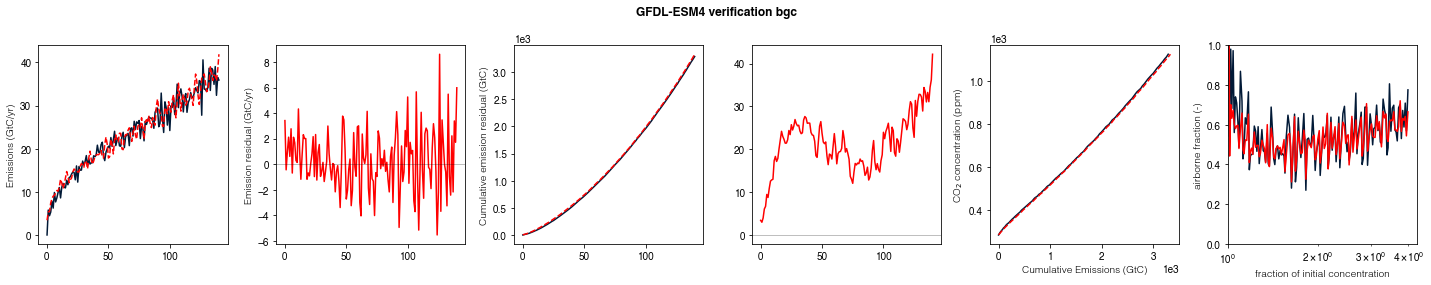

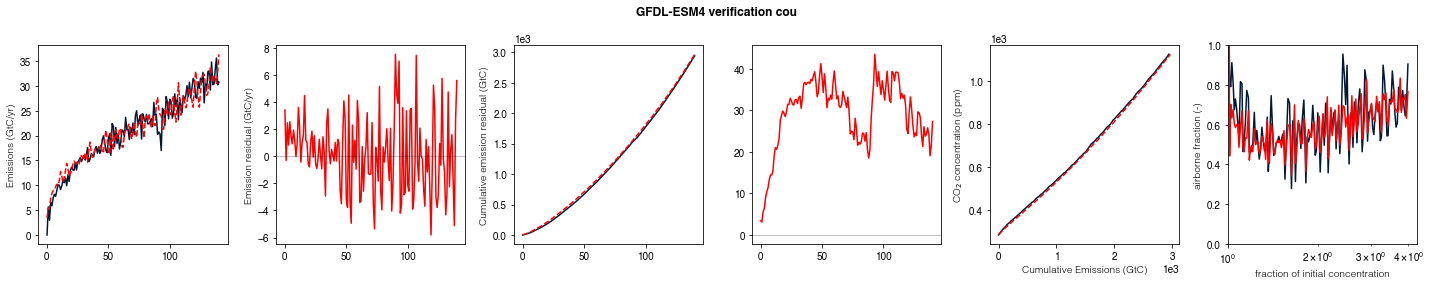

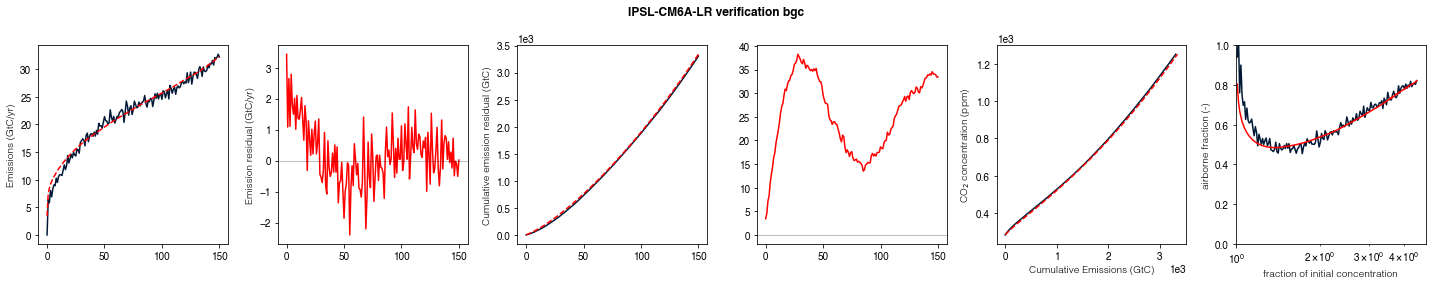

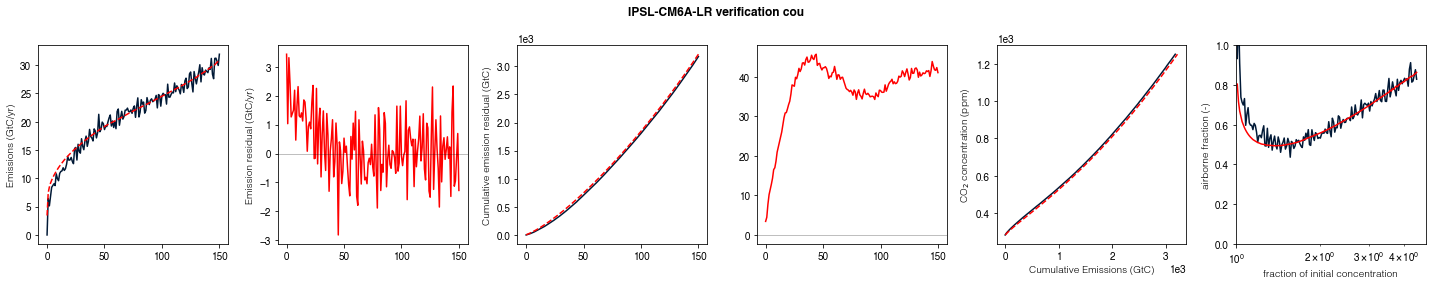

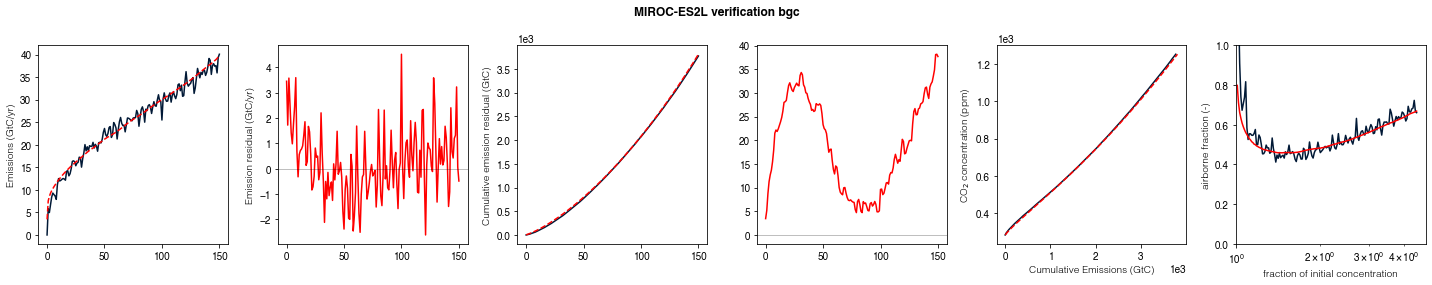

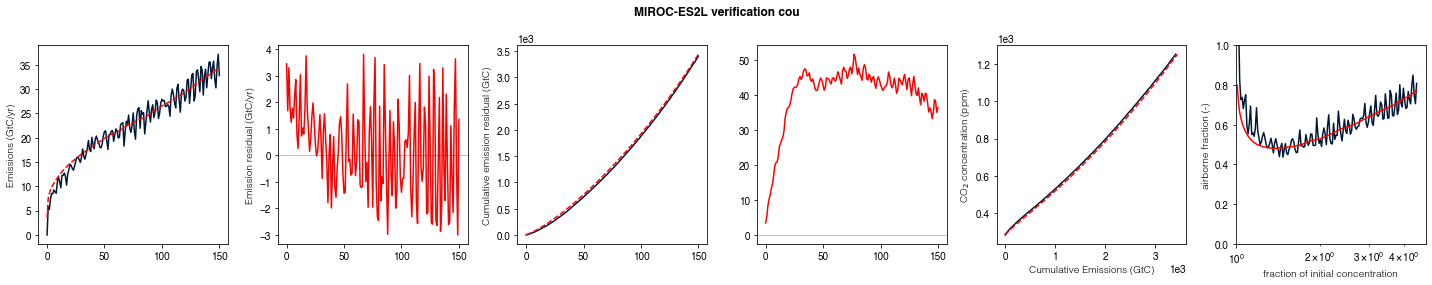

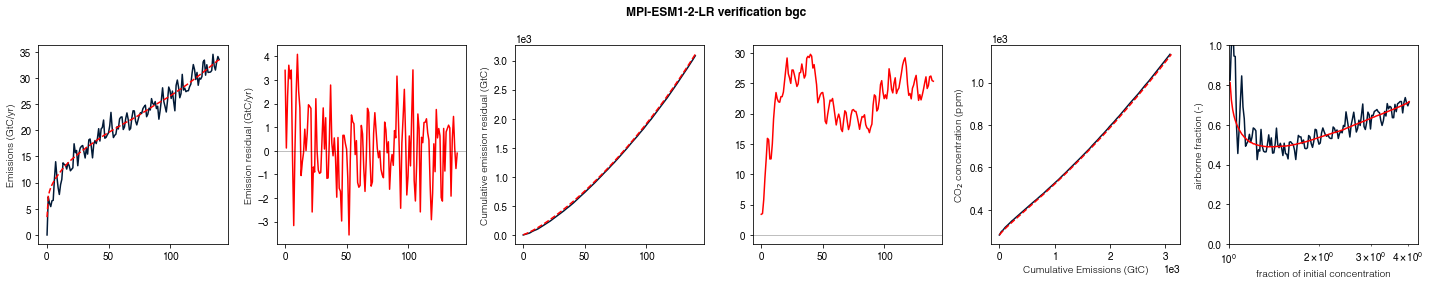

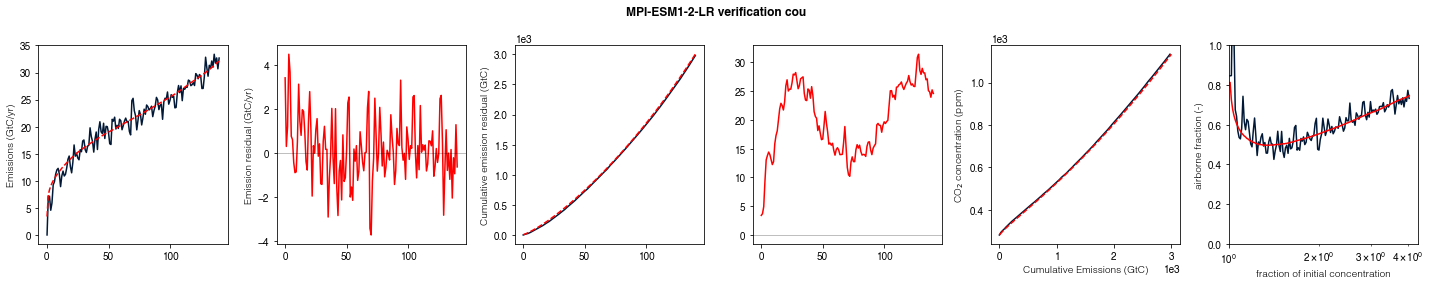

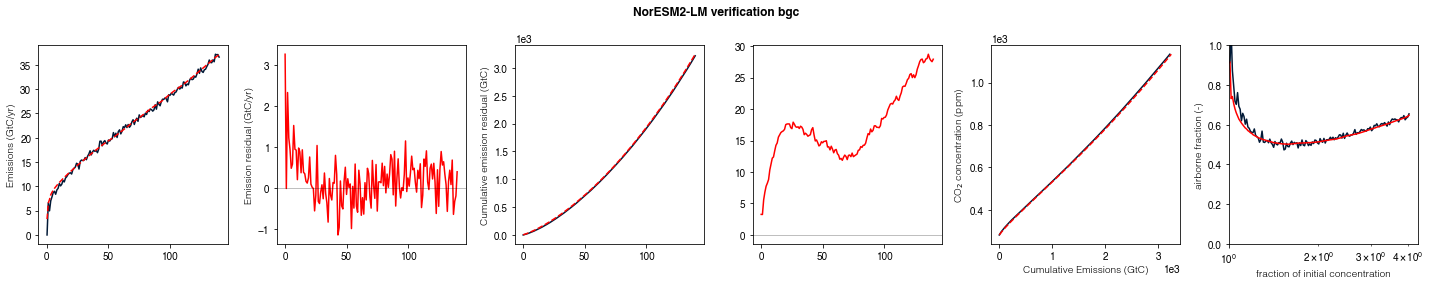

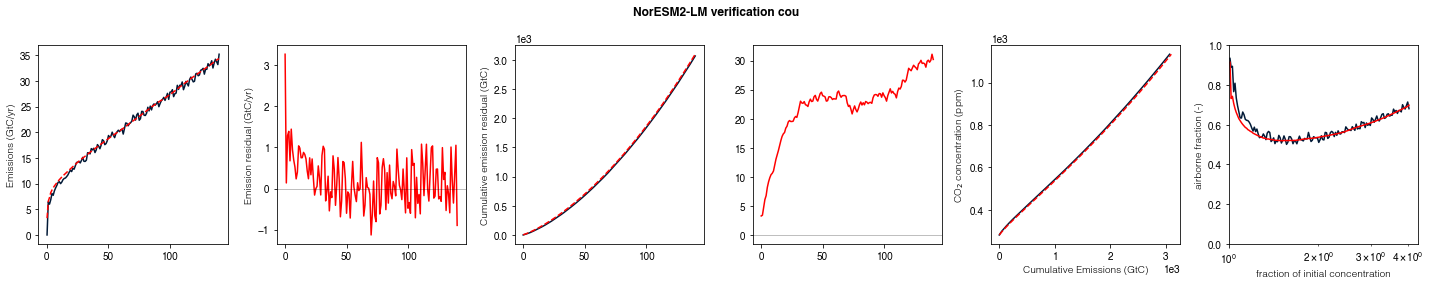

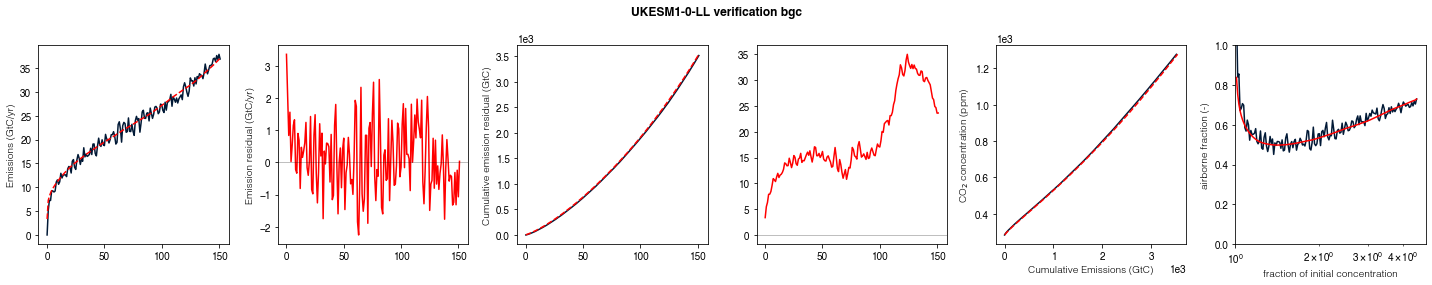

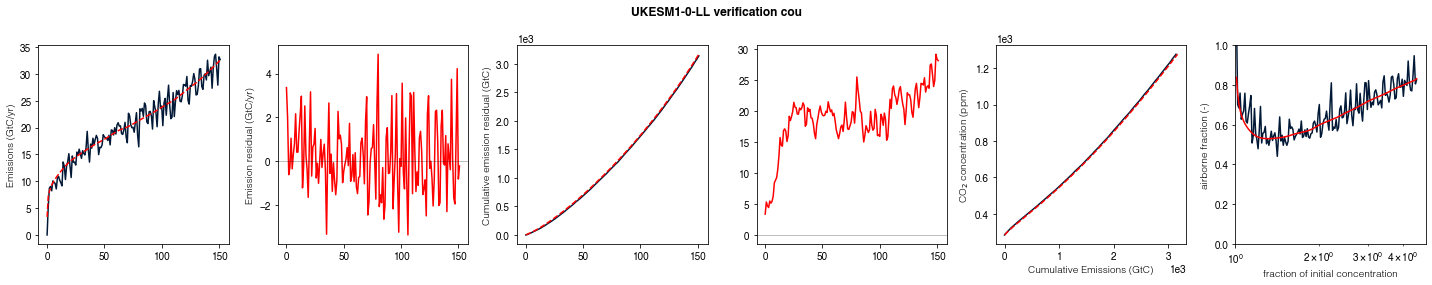

In [33]:
for model in C4MIP_data_1.columns.levels[0]:
    
    if model in ['GFDL-ESM4','CNRM-ESM2-1']: # GFDL tags on 10 years of flat concs at the end which screws with the fit / CNRM only has 139 years for some variables
        data_length = 139
    else:
        data_length=150

    atms_burden = pd.concat([(C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'CO2')].dropna()-C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'CO2')].dropna().iloc[0]/1.01)/4.688876e-01 for x in ['','-bgc','-rad']],axis=1)
    cum_emms = pd.concat([C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'flux')].dropna().cumsum() for x in ['','-bgc','-rad']],axis=1) + atms_burden.values
    concs = C4MIP_data_1.loc[:data_length,(model,'1pctCO2','CO2')].dropna()
    temps = pd.concat([C4MIP_data_1.loc[:data_length,(model,'1pctCO2'+x,'tas')].dropna()for x in ['','-bgc','-rad']],axis=1)
    
    b,w = sp.signal.butter(2,0.1)

    C = np.concatenate(([concs.iloc[0]/1.01],concs.values.astype(float)))
    T_bgc = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2-bgc','tas')].values.astype(float))))
    E_bgc = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')])))
    T_cou = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2','tas')].values.astype(float))))
    E_cou = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2','flux')])))
    
    fig,ax = plt.subplots(1,6,figsize=(20,4))
    r_verify = np.array([*cc_OLSE_results.loc[model,['r0','rC','rT','rA']].values])
    verify_tuning(ax,C,T_bgc,E_bgc,r_verify,C[0],color='red')
    fig.suptitle(model+' verification bgc',fontweight='bold')
    plt.tight_layout()
    fig.patch.set_facecolor('white')
#     fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/cc_tuning_verification/'+model+'_BGC_verification.png',bbox_inches='tight',dpi=600)
    
    fig,ax = plt.subplots(1,6,figsize=(20,4))
    verify_tuning(ax,C,T_cou,E_cou,r_verify,C[0],color='red')
    fig.suptitle(model+' verification cou',fontweight='bold')
    plt.tight_layout()
    fig.patch.set_facecolor('white')
#     fig.savefig('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/Plots/cc_tuning_verification/'+model+'_COU_verification.png',bbox_inches='tight',dpi=600)

<AxesSubplot:>

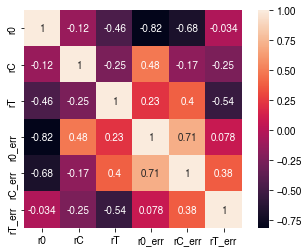

In [95]:
sn.heatmap(cc_OLSE_results.apply(pd.to_numeric).corr(),square=True,annot=True)

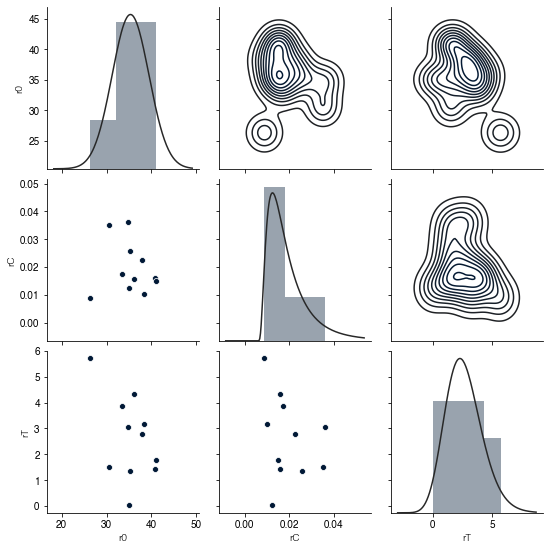

In [33]:
g = sn.PairGrid(cc_OLSE_results,diag_sharey=False)

g.map_upper(sn.kdeplot)
g.map_lower(sn.scatterplot)
g.map_diag(sn.distplot,kde=False,fit=sp.stats.lognorm)

In [34]:
cc_OLSE_results.to_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_240820_byOLSE_plus_rA.csv')

$r_A = 0.0125 - 0.44 \cdot r_C$

In [36]:
### do the range of carbon-cycle parameters (plus the range of response parameters) span the range of CMIP6 response [no forcing uncertainty]?

idealised_test_concs = pd.DataFrame(284*1.01**(np.arange(200)),index=np.arange(200),columns=pd.MultiIndex.from_product([['1pctCO2'],['carbon_dioxide']]))
idealised_test_concs.loc[:,('abrupt_4xCO2','carbon_dioxide')] = 284*4
idealised_test_concs.loc[:,('abrupt_2xCO2','carbon_dioxide')] = 284*2

In [37]:
default_test_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',index_col=0,header=[0,1]).reindex(['carbon_dioxide'],axis=1,level=1)['default']
default_test_params.loc['PI_conc'] = 284

In [38]:
def get_gas_params(N,mem_names=False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
        
    r0 = sp.stats.norm(cc_OLSE_results.r0.mean(),cc_OLSE_results.r0.std()).rvs(N)
    rC = np.exp(sp.stats.norm(np.log(cc_OLSE_results.rC.astype(float)).mean(),np.log(cc_OLSE_results.rC.astype(float)).std()).rvs(N))#sp.stats.uniform(-0.01,0.03).rvs(N)
    rT = sp.stats.norm(cc_OLSE_results.rT.mean(),cc_OLSE_results.rT.std()).rvs(N)#sp.stats.norm(2,1.4).rvs(N)
#     rA = 00.0125 - 0.44 * rC
    
    gas_param_ensemble = pd.concat([default_test_params]*N,axis=1,keys=mem_names)
    
    gas_param_ensemble.loc['r0':'rT'] = np.array([r0,rC,rT])
    
    return gas_param_ensemble

In [39]:
def get_response_params(N,mem_names = False):
    
    if mem_names is False:
        mem_names = ['mem'+str(x) for x in np.arange(N)]
    
    ## require gas_params for the F_2x value

    ## draw ln d1, ln d2, q1 | ln d3 | RWF | TCR

    # covariance of ln_d1, d2, q1
    cov_mat_1 = np.array([[0.95199915, 0.47649902, 0.09359745], [0.47649902, 0.59388914, 0.09119872], [0.09359745, 0.09119872, 0.01710808]])

    mean_mat_1 = np.array([-0.20227299,  2.05243353,  0.20285564])
    
    ln_d3_mean = 5.76338587
    ln_d3_std = 0.57722689
    
    # we alter the CMIP6 assessed ranges to cover a slighly wider range
    RWF_mean = 0.55 # 0.55124171
    RWF_std = 0.3/1.645 # 0.13777385
    
    TCR_mean = 2# 2.0782074
    TCR_std = 1/1.645# 0.45012178

    F_2x = default_test_params.loc['f1','carbon_dioxide'] * np.log(2) + default_test_params.loc['f3','carbon_dioxide'] * (np.sqrt(278*2) - np.sqrt(278))

    lnd1 , lnd2 , q1 , RWF , lnd3 , TCR , d1, d2, d3 , ECS , v1 , v2 , v3 , q2 , q3 = np.empty((15,N))

    neg_idx = np.ones(N).astype(bool)
    N_neg = neg_idx.sum()

    while N_neg>0:

        lnd1[neg_idx], lnd2[neg_idx], q1[neg_idx] = sp.stats.multivariate_normal(mean_mat_1,cov_mat_1).rvs(N_neg).T
        lnd3[neg_idx] = sp.stats.norm(ln_d3_mean, ln_d3_std).rvs(N_neg)
        RWF[neg_idx] = sp.stats.truncnorm(-3,3,RWF_mean, 0.15).rvs(N_neg)
        TCR[neg_idx] = sp.stats.truncnorm(-3,3,TCR_mean, TCR_std).rvs(N_neg)
#         RWF[neg_idx] = sp.stats.uniform(0.25,0.6).rvs(N_neg)
#         TCR[neg_idx] = sp.stats.uniform(1,2).rvs(N_neg)
#         RWF[neg_idx] = sp.stats.norm(0.55,0.15).rvs(N_neg)
#         TCR[neg_idx] = sp.stats.norm(2.05,0.5).rvs(N_neg)
        d1[neg_idx] = np.exp(lnd1[neg_idx])
        d2[neg_idx] = np.exp(lnd2[neg_idx])
        d3[neg_idx] = np.exp(lnd3[neg_idx])
        ECS[neg_idx] = TCR[neg_idx]/RWF[neg_idx]

        v1[neg_idx] = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )[neg_idx]
        v2[neg_idx] = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )[neg_idx]
        v3[neg_idx] = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )[neg_idx]

        q3[neg_idx] = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))[neg_idx]
        q2[neg_idx] = (ECS/F_2x - q1 -  q3)[neg_idx]

        neg_idx = np.any(np.array([d1,d2,d3,q1,q2,q3])<0,axis=0)
        N_neg = neg_idx.sum()

    response_par_ensemble = np.array([d1,d2,d3,q1,q2,q3]).T
    thermal_parameter_ensemble = pd.concat([get_thermal_parameter_defaults()['default'].copy()]*N,axis=1,keys=mem_names)
    thermal_parameter_ensemble.loc[:] = response_par_ensemble.reshape(N,2,3).swapaxes(0,1).reshape(2,-1)
    
    return thermal_parameter_ensemble

In [40]:
response_param_ensemble = get_response_params(10000)

In [41]:
gas_param_ensemble = get_gas_params(10000)

In [42]:
idealised_test = run_GIR(concentrations_in=idealised_test_concs,gas_parameters=gas_param_ensemble,thermal_parameters=response_param_ensemble)
gas_param_ensemble_bgc = gas_param_ensemble.copy()
gas_param_ensemble_bgc.loc['rT'] = 0 
idealised_test_bgc = run_GIR(concentrations_in=idealised_test_concs,gas_parameters=gas_param_ensemble_bgc,thermal_parameters=response_param_ensemble)

Integrating 3 scenarios, 10000 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 199...


100%|██████████| 199/199 [00:02<00:00, 91.52 timestep/s]


Integrating 3 scenarios, 10000 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 199...


100%|██████████| 199/199 [00:02<00:00, 88.98 timestep/s]


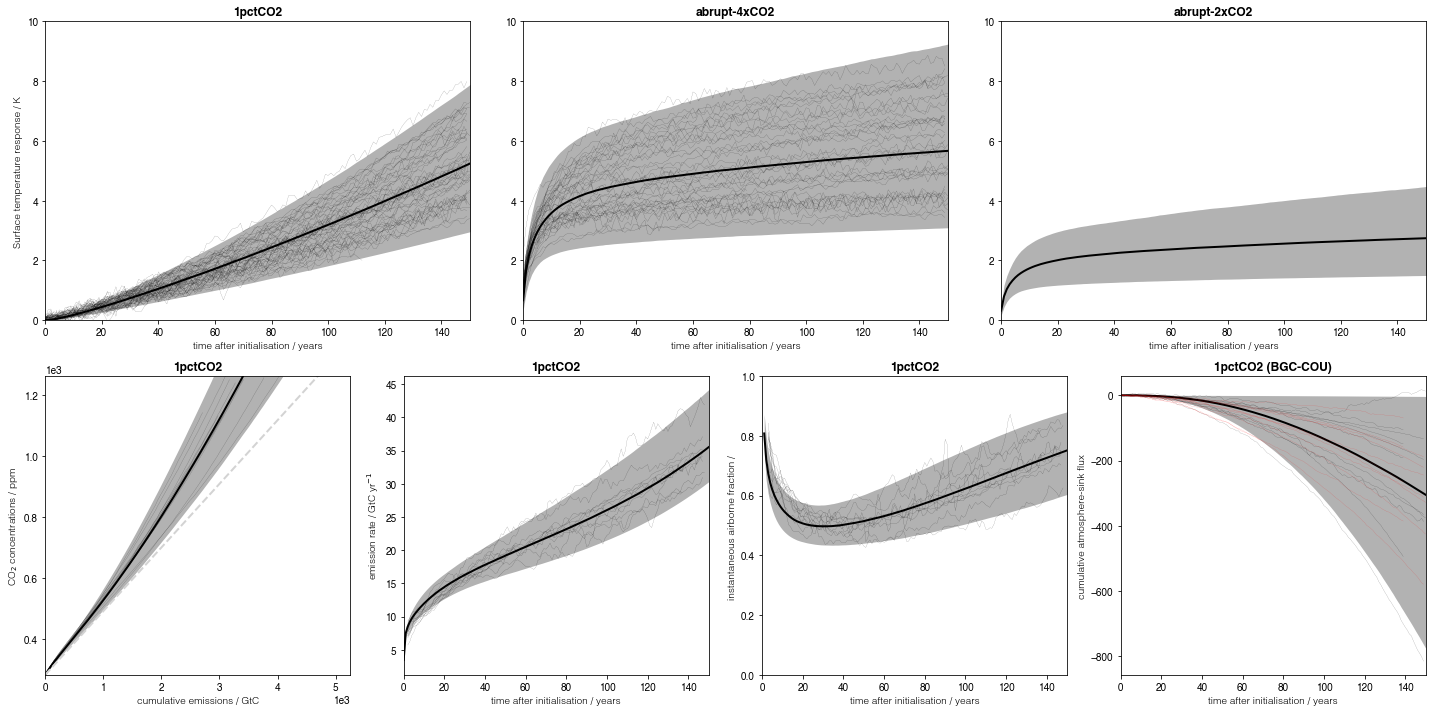

In [43]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(2, 12)
ax1 = [fig.add_subplot(gs[0,4*i:4*(i+1)]) for i in np.arange(3)]
ax2 = [fig.add_subplot(gs[1,3*i:3*(i+1)]) for i in np.arange(4)]

## 1pctCO2 response

ax1[0].fill_between(np.arange(200),*np.quantile(idealised_test['T']['1pctCO2'],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax1[0].plot(np.arange(200),np.quantile(idealised_test['T']['1pctCO2'],0.5,axis=1),color='k',lw=2)

onepct_data_corr.apply(pd.to_numeric).groupby(axis=1,level=0).mean().plot(ax=ax1[0],color='k',lw=0.1,legend=None)

## abrupt4x response

ax1[1].fill_between(np.arange(200),*np.quantile(idealised_test['T']['abrupt_4xCO2'],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax1[1].plot(np.arange(200),np.quantile(idealised_test['T']['abrupt_4xCO2'],0.5,axis=1),color='k',lw=2)

abrupt_4x_data_corr.xs('tas',axis=1,level=-1).apply(pd.to_numeric).groupby(axis=1,level=0).mean().plot(ax=ax1[1],color='k',lw=0.1,legend=None)

## abrupt2x response

ax1[2].fill_between(np.arange(200),*np.quantile(idealised_test['T']['abrupt_2xCO2'],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax1[2].plot(np.arange(200),np.quantile(idealised_test['T']['abrupt_2xCO2'],0.5,axis=1),color='k',lw=2)

[a.set_xlim(0,150) for a in ax1]
[a.set_ylim(0,10) for a in ax1]
ax1[0].set_ylabel('Surface temperature response / K')
[a.set_xlabel('time after initialisation / years') for a in ax1]
[ax1[i].set_title(x,fontweight='bold') for i,x in enumerate(['1pctCO2','abrupt-4xCO2','abrupt-2xCO2'])]

## CC plots

## airborne fraction (GCP 2009-2018 = 0.445)

ax2[0].fill_betweenx(idealised_test['C']['1pctCO2']['carbon_dioxide'].loc[:150],*np.quantile(idealised_test['Emissions']['1pctCO2'].cumsum().loc[:150],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax2[0].plot(np.quantile(idealised_test['Emissions']['1pctCO2'].cumsum().loc[:150],0.5,axis=1),idealised_test['C']['1pctCO2']['carbon_dioxide'].loc[:150],color='k',lw=2)

ax2[0].plot(C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('emms',axis=1,level=1).cumsum(),C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('CO2',axis=1,level=1),color='k',lw=0.1)

ax2[0].plot([0,5000],[284,284+5000*0.445*4.688876e-01],lw=2,ls='--',color='lightgrey')

ax2[0].set_ylim(284,284*1.01**150)
ax2[0].set_xlim(xmin=0)

## emission rate

ax2[1].fill_between(np.arange(151),*np.quantile(idealised_test['Emissions']['1pctCO2'].loc[:150],[0.05,0.95],axis=1),alpha=0.3,color='k',lw=0)
ax2[1].plot(np.arange(151),np.quantile(idealised_test['Emissions']['1pctCO2'].loc[:150],0.5,axis=1),color='k',lw=2)

ax2[1].plot(C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('emms',axis=1,level=1).rolling(5,center=True).mean(),color='k',lw=0.1)

## airborne fraction

ax2[2].fill_between(np.arange(151),*np.quantile(idealised_test['C']['1pctCO2'].loc[:150].diff().values/4.688876e-01/idealised_test['Emissions']['1pctCO2'].loc[:150],[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax2[2].plot(np.arange(151),np.quantile(idealised_test['C']['1pctCO2'].loc[:150].diff().values/4.688876e-01/idealised_test['Emissions']['1pctCO2'].loc[:150],0.5,axis=1),color='k',lw=2)

ax2[2].plot(C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('CO2',axis=1,level=1).diff().rolling(5,center=True).mean()/4.688876e-01/C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('emms',axis=1,level=1).rolling(5,center=True).mean(),color='k',lw=0.1)
# ax2[2].plot((C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('CO2',axis=1,level=1)-C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('CO2',axis=1,level=1).iloc[0]/1.01)/4.688876e-01/C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('emms',axis=1,level=1).cumsum(),color='k',lw=0.1)

ax2[2].set_ylim(0,1)

## effective RAD flux

ax2[3].fill_between(np.arange(151),*np.quantile((idealised_test['Emissions']['1pctCO2']-idealised_test_bgc['Emissions']['1pctCO2']).loc[:150].cumsum(),[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax2[3].plot(np.arange(151),np.quantile((idealised_test['Emissions']['1pctCO2']-idealised_test_bgc['Emissions']['1pctCO2']).loc[:150].cumsum(),0.5,axis=1),color='k',lw=2)

ax2[3].plot(C4MIP_data_1.xs('1pctCO2',axis=1,level=1).xs('flux',axis=1,level=1).cumsum()-C4MIP_data_1.xs('1pctCO2-bgc',axis=1,level=1).xs('flux',axis=1,level=1).cumsum(),color='k',lw=0.1)
ax2[3].plot(C4MIP_data_1.xs('1pctCO2-rad',axis=1,level=1).xs('flux',axis=1,level=1).cumsum(),color='red',alpha=0.8,lw=0.1)

[ax2[i].set_ylabel(x) for i,x in enumerate(['CO$_2$ concentrations / ppm','emission rate / GtC yr$^{-1}$','instantaneous airborne fraction / ','cumulative atmosphere-sink flux'])]
[ax2[i].set_xlabel(x) for i,x in enumerate(['cumulative emissions / GtC','time after initialisation / years','time after initialisation / years','time after initialisation / years'])]
[ax2[i].set_title(x,fontweight='bold') for i,x in enumerate(['1pctCO2','1pctCO2','1pctCO2','1pctCO2 (BGC-COU)'])]

[a.set_xlim(0,150) for a in ax2[1:]]

plt.tight_layout()

In [50]:
np.exp(np.log(cc_OLSE_results.rC.astype(float)).mean())

0.017701458306524937

In [1]:
cc_OLSE_results.rT.mean()

NameError: name 'cc_OLSE_results' is not defined

## Number of members per experiment

In [12]:
## get the actual historical / ssp data:
ssp_tas = pd.read_csv('../tools/cmip6_data/ssp_tas.csv',index_col=0)
hist_tas = pd.read_csv('../tools/cmip6_data/hist_tas.csv',index_col=0).iloc[1:]

for i,x in enumerate(['source','member','variable','experiment']):
    ssp_tas.loc[x] = [x.split('_')[i+1] for x in ssp_tas.columns]
for i,x in enumerate(['source','member']):    
    hist_tas.loc[x] = [x.split('_')[i+1] for x in hist_tas.columns]
    

ssp_tas=ssp_tas.T.set_index(['source','member','experiment']).T.drop('variable').apply(pd.to_numeric)
hist_tas=hist_tas.T.set_index(['source','member']).T.apply(pd.to_numeric)
ssp_tas['year']=[int(x) for x in ssp_tas.index]
ssp_tas = ssp_tas.set_index('year')
ssp_tas = ssp_tas.reindex(np.arange(1850,2301))

hist_tas['year']=[int(x) for x in hist_tas.index]
hist_tas = hist_tas.set_index('year')

for modmem in hist_tas.columns:
    if modmem in ssp_tas.columns.droplevel(-1):
        for exp in ssp_tas.loc[1850:2014,modmem].columns:
            ssp_tas.loc[1850:2014,(*modmem,exp)] = hist_tas.loc[1850:2014,modmem]

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py:536: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [16]:
pd.concat([pd.concat([abrupt_4x_data_corr.loc[0].xs('tas',level=2).groupby(level=0).count(),onepct_data_corr.loc[0].groupby(level=0).count()],axis=1,keys=['abrupt-4xCO2','1pctCO2']),ssp_tas.loc[1850].groupby(level=(0,2)).count().unstack().loc[:,['ssp119','ssp126','ssp245','ssp370','ssp585']]],axis=1).replace(np.nan,0).astype(int)#.to_latex('/home/leachl/Documents/Simple_models/FaIR_v2-0_paper/tmp_tex_tables/CMIP6_no_of_members')

abrupt-4xCO2  1pctCO2  ssp119  ssp126  ssp245  ssp370  ssp585
ACCESS-CM2                  1        1       0       3       3       3       3
ACCESS-ESM1-5               1        1       0       3       3       3       3
AWI-CM-1-1-MR               1        1       0       0       0       0       0
BCC-CSM2-MR                 1        1       0       1       1       1       1
BCC-ESM1                    1        1       0       0       0       3       0
CAMS-CSM1-0                 2        2       2       2       2       2       2
CESM2                       1        1       0       3       3       3       3
CESM2-FV2                   1        1       0       0       0       0       0
CESM2-WACCM                 1        1       0       1       3       3       3
CESM2-WACCM-FV2             1        1       0       0       0       0       0
CIESM                       1        1       0       1       1       0       1
CNRM-CM6-1                  1        1       0       6      10       6       6
CNRM-CM6-1-HR               1        1       0       1       1       1       1
CNRM-ESM2-1                 3       10       5       5       5       5       5
CanESM5                     2        6      50      50      50      50      50
E3SM-1-0                    1        1       0       0       0       0       0
EC-Earth3-Veg               1        1       3       5       6       4       5
GFDL-CM4                    1        1       0       0       1       0       1
GFDL-ESM4                   1        1       1       1       3       1       1
GISS-E2-1-G                 4        5       2       1      10      10       1
GISS-E2-1-H                 1        1       0       0       0       0       0
GISS-E2-2-G                 1        1       0       0       0       0       0
HadGEM3-GC31-LL             1        4       0       1       4       0       4
HadGEM3-GC31-MM             1        1       0       1       0       0       3
INM-CM4-8                   1        1       0       1       1       1       1
INM-CM5-0                   1        1       0       1       1       5       1
IPSL-CM6A-LR                1        1       6       6      11      11       6
KACE-1-0-G                  1        1       0       3       3       3       3
MIROC-ES2L                  1        1       3       3       1       1       1
MIROC6                      1        1       1       3      50       3      50
MPI-ESM1-2-HR               1        1       0       2       2      10       2
MPI-ESM1-2-LR               1        1       0      10      10      10      10
MRI-ESM2-0                  4        2       1       1       5       5       1
NESM3                       1        1       0       2       2       0       2
NorCPM1                     1        1       0       0       0       0       0
NorESM2-LM                  1        1       0       1       3       3       1
NorESM2-MM                  1        1       0       1       1       1       1
SAM0-UNICON                 1        1       0       0       0       0       0
TaiESM1                     1        1       0       0       0       0       0
UKESM1-0-LL                 1        4       5      13       5      13       5
CAS-ESM2-0                  0        1       0       0       0       0       0
CMCC-CM2-SR5                0        1       0       1       1       1       1
CanESM5-CanOE               0        1       0       3       3       3       3
FGOALS-f3-L                 0        3       0       1       1       1       1
FGOALS-g3                   0        3       0       1       1       1       4
FIO-ESM-2-0                 0        3       0       3       3       0       3
IITM-ESM                    0        1       0       0       0       0       0
MCM-UA-1-0                  0        1       0       1       1       1       1
MPI-ESM-1-2-HAM             0        1       0       0       0       2       0
EC-Earth3                   0        0       1       7      16     

In [102]:
## importing .MAG
from zipfile import ZipFile
test = ZipFile('../tools/cmip6_data/unimelb_nbp.zip')
fnames = [x.filename for x in test.infolist() if x.filename[-3:]=='MAG']
data = []
for fname in fnames:
    fdata = test.open(fname)
    lines = fdata.readlines()
    startline = [i for i,l in enumerate(lines) if l.strip()[:5]==b'YEARS'][0]
    fout = pd.DataFrame([x.decode("utf-8").split() for x in lines[startline:]]).set_index(0).T.set_index('YEARS').T.apply(pd.to_numeric)
    data+=[fout]
    
all_data = pd.concat(data,axis=1,keys=fnames)